## Training script for the CNN 

Loads in the converted plane representation of the pgn files, defines the network architecture and starts the training process. Checkpoints of the weights are saved if there's an improvement in the validation loss.
The training performance metrics (e.g. losses, accuracies...) are exported to tensorboard and can be checked during training.
* author: QueensGambit

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%reload_ext autoreload

In [19]:
from __future__ import print_function
import os
import sys
sys.path.insert(0,'../../../')
import glob
import chess
import shutil
import logging
import numpy as np
from pathlib import Path
from copy import deepcopy

from DeepCrazyhouse.src.training.train_util import get_metrics, prepare_policy, value_to_wdl_label, prepare_plys_label
from DeepCrazyhouse.src.domain.variants.input_representation import board_to_planes, planes_to_board
from DeepCrazyhouse.src.domain.variants.output_representation import policy_to_moves, policy_to_best_move, policy_to_move
from DeepCrazyhouse.src.preprocessing.dataset_loader import load_pgn_dataset
from DeepCrazyhouse.src.runtime.color_logger import enable_color_logging
from DeepCrazyhouse.configs.main_config import main_config
from DeepCrazyhouse.configs.train_config import TrainConfig, TrainObjects

from DeepCrazyhouse.src.training.lr_schedules.lr_schedules import *
from DeepCrazyhouse.src.domain.variants.plane_policy_representation import FLAT_PLANE_IDX
from DeepCrazyhouse.src.domain.variants.constants import NB_POLICY_MAP_CHANNELS, NB_LABELS, MODE_CHESS, MODE_CRAZYHOUSE
enable_color_logging()
%matplotlib inline

2023-10-23 00:51:38 matplotlib.pyplot[7116] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-10-23 00:51:38 matplotlib.pyplot[7116] DEBUG Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [20]:
tc = TrainConfig()
to = TrainObjects()
# Decide between 'pytorch', 'mxnet' and 'gluon' style for training
tc.framework: str = 'pytorch'

### pytorch imports

In [21]:
if tc.framework == 'pytorch':
    import torch
    from torch.utils.data import TensorDataset, DataLoader
    from torchsummary import summary
    from fvcore.nn import FlopCountAnalysis

    from DeepCrazyhouse.src.training.trainer_agent_pytorch import TrainerAgentPytorch, save_torch_state,\
    load_torch_state, export_to_onnx, get_context, get_data_loader, evaluate_metrics
    # architectures
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.rise_mobile_v3 import RiseV3, get_rise_v33_model_by_train_config
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.vision_transformer import VisionTransformer
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.vit_configs import get_b8_config
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.le_vit import LeViT
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.mobile_vit import MobileViT
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.trt_vit import TrtViT
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.next_vit_official import NextVit
    from DeepCrazyhouse.src.domain.neural_net.architectures.pytorch.a0_resnet import AlphaZeroResnet

### mxnet imports

In [22]:
if tc.framework == 'mxnet' or tc.framework == 'gluon':
    import mxnet as mx
    from mxnet import nd
    from mxnet import gluon
    try:
        import mxnet.metric as metric
    except ModuleNotFoundError:
        import mxnet.gluon.metric as metrics

    from DeepCrazyhouse.src.training.trainer_agent_gluon import TrainerAgentGluon, evaluate_metrics, acc_sign, get_data_loader
    from DeepCrazyhouse.src.training.trainer_agent_mxnet import TrainerAgentMXNET, get_context
    # architectures
    from DeepCrazyhouse.src.domain.neural_net.architectures.a0_resnet import AlphaZeroResnet
    from DeepCrazyhouse.src.domain.neural_net.architectures.mxnet_alpha_zero import alpha_zero_symbol
    from DeepCrazyhouse.src.domain.neural_net.architectures.rise_mobile_v2 import rise_mobile_v2_symbol
    from DeepCrazyhouse.src.domain.neural_net.architectures.rise_mobile_v3 import rise_mobile_v3_symbol
    from DeepCrazyhouse.src.domain.neural_net.architectures.preact_resnet_se import preact_resnet_se
    from DeepCrazyhouse.src.domain.neural_net.onnx.convert_to_onnx import convert_mxnet_model_to_onnx

## Settings

In [23]:
# set the context on CPU, switch to GPU if there is one available (strongly recommended for training)
tc.context = "gpu"
tc.device_id = 0

# set a specific seed value for reproducibility
tc.seed = 7 # 42

tc.export_weights = True
tc.log_metrics_to_tensorboard = True
tc.export_grad_histograms = False

# directory to write and read weights, logs, onnx and other export files
tc.export_dir = "./"

tc.div_factor = 4  # div factor is a constant which can be used to reduce the batch size and learning rate respectively
# use a value greater 1 if you encounter memory allocation errors

# batch_steps = 1000 means for example that every 1000 batches the validation set gets processed
tc.batch_steps = 1000 * tc.div_factor # this defines how often a new checkpoint will be saved and the metrics evaluated
# k_steps_initial defines how many steps have been trained before
# (k_steps_initial != 0 if you continue training from a checkpoint)
tc.k_steps_initial = 0
# these are the weights to continue training with
tc.symbol_file = None # 'model-0.81901-0.713-symbol.json'
tc.params_file = None #'model-0.81901-0.713-0498.params'

tc.batch_size = int(1024 / tc.div_factor) # 1024 # the batch_size needed to be reduced to 1024 in order to fit in the GPU 1080Ti
#4096 was originally used in the paper -> works slower for current GPU
# 2048 was used in the paper Mastering the game of Go without human knowledge and fits in GPU memory
#typically if you half the batch_size, you should double the lr

# optimization parameters
tc.optimizer_name = "nag"  # "adam" "adamw" # 
if tc.framework == 'pytorch':
    # strangely pytorch should use a different lr than mxnet
    tc.max_lr = 0.07 / tc.div_factor
else:
    tc.max_lr = 0.35 / tc.div_factor #0.01 # default lr for adam
tc.min_lr = 0.00001

if "adam" in tc.optimizer_name:
    tc.max_lr = 0.001001 #1e-3
    tc.min_lr = 0.001
    
tc.max_momentum = 0.95
tc.min_momentum = 0.8
# loads a previous checkpoint if the loss increased significanly
tc.use_spike_recovery = True
# stop training as soon as max_spikes has been reached
tc.max_spikes = 20
# define spike threshold when the detection will be triggered
tc.spike_thresh = 1.5
# weight decay
tc.wd = 1e-4
tc.dropout_rate = 0 #0.15

# enables training with a wdl head as intermediate target (mainly useful for environments with 3 outcomes)
tc.use_wdl = True
# enables training with ply to end head
tc.use_plys_to_end = True
# adds a small mlp to infer the value loss from wdl and plys_to_end_output
tc.use_mlp_wdl_ply = False

# weight the value loss a lot lower than the policy loss in order to prevent overfitting
tc.val_loss_factor = 0.01
tc.policy_loss_factor = 0.988 if tc.use_plys_to_end else 0.99
tc.plys_to_end_loss_factor = 0.002
tc.wdl_loss_factor = 0.01
tc.discount = 1.0

tc.normalize = True # define whether to normalize input data to [0,1]
tc.nb_training_epochs = 7 # define how many epochs the network will be trained
tc.select_policy_from_plane = True # Boolean if potential legal moves will be selected from final policy output
        
# additional custom validation set files which will be logged to tensorboard
to.variant_metrics = None # ["chess960", "koth", "three_check"]
# if use_extra_variant_input is true the current active variant is passed two each residual block and

# ratio for mixing the value return with the corresponding q-value
# for a ratio of 0 no q-value information will be used
tc.q_value_ratio = 0

# define if policy training target is one-hot encoded a distribution (e.g. mcts samples, knowledge distillation)
tc.sparse_policy_label = True
# define if the policy data is also defined in "select_policy_from_plane" representation
tc.is_policy_from_plane_data = False
tc.name_initials = "JC"

In [24]:
mode = main_config["mode"]
ctx = get_context(tc.context, tc.device_id)
# concatenated at the end of the final feature representation
use_extra_variant_input = False
cur_it = tc.k_steps_initial * tc.batch_steps # iteration counter used for the momentum and learning rate schedule

In [25]:
if tc.framework == 'mxnet' or tc.framework == 'gluon':
    # Fixing the random seed
    mx.random.seed(tc.seed)
    mx.__version__

### Create logs and weights directory

In [26]:
if not os.path.exists(tc.export_dir + "logs"):
    os.mkdir(tc.export_dir + "logs")
if not os.path.exists(tc.export_dir + "weights"):
    os.mkdir(tc.export_dir + "weights")

### Show the config files

In [27]:
print(main_config)

{'pgn_train_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/train/', 'pgn_val_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/val/', 'pgn_test_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/test/', 'pgn_mate_in_one_dir': '/home/demo_user/datasets/lichess/Crazyhouse/pgn/mate_in_one/', 'planes_train_dir': 'D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/train/', 'planes_val_dir': 'D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/val/', 'planes_test_dir': 'D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/test/', 'planes_mate_in_one_dir': 'D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/mate_in_one/', 'rec_dir': '/home/demo_user/datasets/lichess/Crazyhouse/rec/', 'model_architecture_dir': '/home/demo_user/models/Crazyhouse/symbol/', 'model_weights_dir': '/home/demo_user/models/Crazyhouse/params/', 'value_output': 'value_out', 'policy_output': 'policy_out', 'auxiliary_output': 'auxiliary_out', 'wdl_output': 'wdl_out', '

In [28]:
print(tc)

TrainConfig(div_factor=4, batch_size=256, batch_steps=4000, context='gpu', cpu_count=4, device_id=0, discount=1.0, dropout_rate=0, export_dir='./', export_weights=True, export_grad_histograms=False, framework='pytorch', is_policy_from_plane_data=False, log_metrics_to_tensorboard=True, k_steps_initial=0, symbol_file=None, params_file=None, optimizer_name='nag', max_lr=0.0175, min_lr=1e-05, max_momentum=0.95, min_momentum=0.8, max_spikes=20, name_initials='JC', nb_parts=None, normalize=True, nb_training_epochs=7, policy_loss_factor=0.988, plys_to_end_loss_factor=0.002, q_value_ratio=0, seed=7, select_policy_from_plane=True, spike_thresh=1.5, sparse_policy_label=True, total_it=None, use_mlp_wdl_ply=False, use_plys_to_end=True, use_wdl=True, use_spike_recovery=True, val_loss_factor=0.01, wdl_loss_factor=0.01, wd=0.0001)


In [29]:
print(to)

TrainObjects()


### Load the dataset-files

### Validation Dataset (which is used during training)

In [30]:
s_idcs_val, x_val, yv_val, yp_val, plys_to_end, pgn_datasets_val = load_pgn_dataset(dataset_type='val', part_id=0,
                                                                           verbose=True, normalize=tc.normalize)
if tc.discount != 1:
    yv_val *= tc.discount**plys_to_end
    
if tc.framework == 'mxnet':
    if tc.select_policy_from_plane:
        if tc.use_wdl and tc.use_wdl:
            val_iter = mx.io.NDArrayIter({'data': x_val},
                                         {'value_label': yv_val,
                                          'policy_label': np.array(FLAT_PLANE_IDX)[yp_val.argmax(axis=1)],
                                          'wdl_label': value_to_wdl_label(yv_val),
                                          'plys_to_end_label': prepare_plys_label(plys_to_end)},
                                          tc.batch_size)
        else:
            val_iter = mx.io.NDArrayIter({'data': x_val},
                                         {'value_label': yv_val,
                                          'policy_label': np.array(FLAT_PLANE_IDX)[yp_val.argmax(axis=1)]},
                                         tc.batch_size)
    else:
        val_iter = mx.io.NDArrayIter({'data': x_val}, {'value_label': yv_val, 'policy_label': yp_val.argmax(axis=1)}, tc.batch_size)
elif tc.framework == 'gluon' or tc.framework == 'pytorch':
    val_data = get_data_loader(x_val, yv_val, yp_val, plys_to_end, tc, shuffle=False)

2023-10-23 00:51:40 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/val\2021-01-12-14-14-24\lichess_db_crazyhouse_rated_2018-04_0.zip ...
2023-10-23 00:51:40 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/val\2021-01-12-14-14-24\lichess_db_crazyhouse_rated_2018-04_0.zip ...
2023-10-23 00:51:40 root[7116] DEBUG 
2023-10-23 00:51:40 root[7116] DEBUG 
2023-10-23 00:51:41 root[7116] INFO STATISTICS:
2023-10-23 00:51:41 root[7116] INFO STATISTICS:
black_wins [444]
draws [2]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [554]
2023-10-23 00:51:41 root[7116] INFO PARAMETERS:
2023-10-23 00:51:41 root[7116] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-04.pgn']
termination_conditions [b'Normal']


In [31]:
tc.nb_parts = len(glob.glob(main_config['planes_train_dir'] + '**/*'))

In [32]:
nb_it_per_epoch = (len(x_val) * tc.nb_parts) // tc.batch_size # calculate how many iterations per epoch exist
# one iteration is defined by passing 1 batch and doing backprop
tc.total_it = int(nb_it_per_epoch * tc.nb_training_epochs)
tc.total_it

37758

### Define a Learning Rate schedule

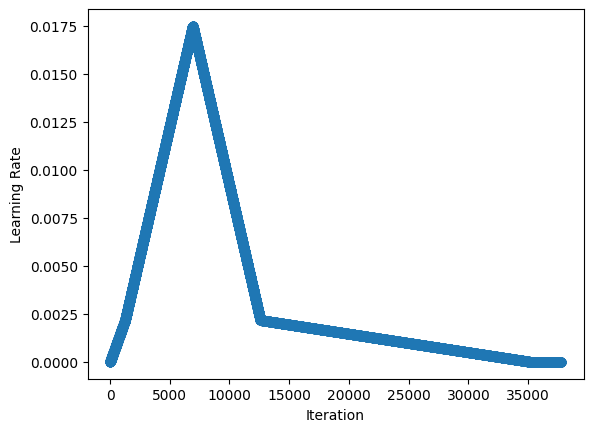

In [33]:
if "adam" in tc.optimizer_name:
    to.lr_schedule = ConstantSchedule(tc.min_lr)
else:
    to.lr_schedule = OneCycleSchedule(start_lr=tc.max_lr/8, max_lr=tc.max_lr, cycle_length=tc.total_it*.3, cooldown_length=tc.total_it*.6, finish_lr=tc.min_lr)
to.lr_schedule = LinearWarmUp(to.lr_schedule, start_lr=tc.min_lr, length=tc.total_it/30)

logging.getLogger().setLevel(logging.WARNING)
plot_schedule(to.lr_schedule, iterations=tc.total_it)
logging.getLogger().setLevel(logging.DEBUG)

### Momentum schedule

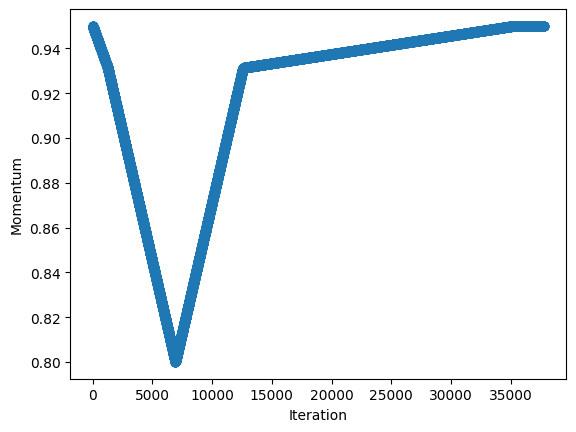

In [34]:
to.momentum_schedule = MomentumSchedule(to.lr_schedule, tc.min_lr, tc.max_lr, tc.min_momentum, tc.max_momentum)
plot_schedule(to.momentum_schedule, iterations=tc.total_it, ylabel='Momentum')

### Create the model

In [35]:
input_shape = x_val[0].shape
input_shape

(34, 8, 8)

In [36]:
try:
    del net
except:
    pass

### Define the NN model / Load the pretrained model

### MXNet model definitions

In [37]:
symbol = None

In [38]:
net = AlphaZeroResnet(n_labels=NB_LABELS, channels=192, channels_value_head=8, channels_policy_head=NB_POLICY_MAP_CHANNELS, num_res_blocks=18, value_fc_size=256, act_type='relu', select_policy_from_plane= tc.select_policy_from_plane)

In [39]:
# net = AlphaZeroResnet(n_labels=2272, channels=256, channels_value_head=8, channels_policy_head=81, num_res_blocks=19, value_fc_size=256, bn_mom=0.9, act_type='relu', select_policy_from_plane=select_policy_from_plane)


In [40]:
#net = alpha_zero_resnet(n_labels=2272, channels=256, channels_value_head=1, channels_policy_head=81, num_res_blocks=19, value_fc_size=256, bn_mom=0.9, act_type='relu')

In [41]:
#symbol = alpha_zero_symbol(num_filter=256, channels_value_head=4, channels_policy_head=81, workspace=1024, value_fc_size=256, num_res_blocks=19, bn_mom=0.9, act_type='relu',
#                            n_labels=2272, grad_scale_value=0.01, grad_scale_policy=0.99, select_policy_from_plane=select_policy_from_plane)

In [42]:
# bc_res_blocks = [3] * 13
# if tc.symbol_file is None:
#    symbol = rise_mobile_v2_symbol(channels=256, channels_operating_init=128, channel_expansion=64, channels_value_head=8,
#                      channels_policy_head=NB_POLICY_MAP_CHANNELS, value_fc_size=256, bc_res_blocks=bc_res_blocks, res_blocks=[], act_type='relu',
#                      n_labels=NB_LABELS, grad_scale_value=tc.val_loss_factor, grad_scale_policy=tc.policy_loss_factor, select_policy_from_plane=tc.select_policy_from_plane,
#                      use_se=True, dropout_rate=tc.dropout_rate, use_extra_variant_input=use_extra_variant_input)
# else:
#    symbol = mx.sym.load(tc.export_dir + "weights/" + tc.symbol_file)

kernels = [3] * 15
kernels[7] = 5
kernels[11] = 5
kernels[12] = 5
kernels[13] = 5

se_types = [None] * len(kernels)
se_types[5] = "eca_se"
se_types[8] = "eca_se"
se_types[12] = "eca_se"
se_types[13] = "eca_se"
se_types[14] = "eca_se"

kernels = [3] * 7

se_types = [None] * len(kernels)
se_types[5] = "eca_se"


symbol = rise_mobile_v3_symbol(channels=256, channels_operating_init=224, channel_expansion=32, act_type='relu',
                               channels_value_head=8, value_fc_size=256,
                               channels_policy_head=NB_POLICY_MAP_CHANNELS,
                               grad_scale_value=tc.val_loss_factor,
                               grad_scale_policy=tc.policy_loss_factor,
                               grad_scale_wdl=tc.wdl_loss_factor,
                               grad_scale_ply=tc.plys_to_end_loss_factor,
                               dropout_rate=tc.dropout_rate, select_policy_from_plane=True,
                               kernels=kernels, se_types=se_types, use_avg_features=False,
                               use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end,
                               use_mlp_wdl_ply=tc.use_mlp_wdl_ply
                               )

kernels = [3,3,3,3,3,3,5,5]

se_types = [
    None, # 1
    None, # 2
    None,  # 3
    "eca_se",  # 4
    None, # 5
    None,  # 6
    None, # 7
    "eca_se", # 8
] 

symbol = preact_resnet_se(channels=288, act_type='relu',
                          channels_value_head=8, value_fc_size=256,
                          channels_policy_head=NB_POLICY_MAP_CHANNELS,
                          grad_scale_value=tc.val_loss_factor, grad_scale_policy=tc.policy_loss_factor, 
                          dropout_rate=tc.dropout_rate, select_policy_from_plane=True,
                          kernels=kernels, se_types=se_types, use_avg_features=True, use_raw_features=True)

### Pytorch model definitions

In [43]:
model = get_rise_v33_model_by_train_config(input_shape, tc)

model = LeViT(
    image_size = input_shape[1],
    in_channels = input_shape[0],
    channels_policy_head = NB_POLICY_MAP_CHANNELS,
    stages = 1,             # number of stages
    dim = (256,),  # dimensions at each stage
    depth = 9,              # transformer of depth 4 at each stage
    heads = (4,),      # heads at each stage
    mlp_mult = 2,
    dropout = 0.1,
    select_policy_from_plane=tc.select_policy_from_plane,
    use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end,
    use_mlp_wdl_ply=tc.use_mlp_wdl_ply,    
)

model = MobileViT(
    image_size = (input_shape[1], input_shape[2]),
    in_channels = input_shape[0],
    dims = [96, 120, 144],
    channels = 256,
    channels_policy_head = NB_POLICY_MAP_CHANNELS,
    select_policy_from_plane=tc.select_policy_from_plane,
    use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end,
    use_mlp_wdl_ply=tc.use_mlp_wdl_ply,
)

model = TrtViT(
    image_size = input_shape[1],
    in_channels = input_shape[0],
    channels_policy_head = NB_POLICY_MAP_CHANNELS,
    channels=256,
    select_policy_from_plane=tc.select_policy_from_plane,
    use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end,
    use_mlp_wdl_ply=tc.use_mlp_wdl_ply,  
    )

kernels = [3] * 12 #15
kernels[10] = 5
kernels[9] = 5
kernels[5] = 5
#kernels[13] = 5

use_transformers = [False] * len(kernels)
use_transformers[11] = True
#use_transformers[9] = True
#use_transformers[4] = True

se_types = [None] * len(kernels)
se_types[5] = "eca_se"
se_types[11] = "eca_se"
#se_types[12] = "eca_se"
#se_types[13] = "eca_se"
#se_types[14] = "eca_se"

class Args:
    pass

args = Args()
args.input_shape = input_shape
args.channels_policy_head = NB_POLICY_MAP_CHANNELS
args.n_labels = NB_LABELS
args.select_policy_from_plane = tc.select_policy_from_plane
args.use_wdl = tc.use_wdl
args.use_plys_to_end = tc.use_plys_to_end
args.use_mlp_wdl_ply = tc.use_mlp_wdl_ply

model = RiseV3(nb_input_channels=args.input_shape[0], board_height=args.input_shape[1], board_width=args.input_shape[2],
                channels=256, channels_operating_init=224, channel_expansion=32,
                channels_value_head=8, value_fc_size=256,
                channels_policy_head=args.channels_policy_head,
                dropout_rate=0, select_policy_from_plane=args.select_policy_from_plane,
                kernels=kernels, se_types=se_types, use_avg_features=False, n_labels=args.n_labels,
                use_wdl=args.use_wdl, use_plys_to_end=args.use_plys_to_end, use_mlp_wdl_ply=args.use_mlp_wdl_ply,
                use_transformers=use_transformers, path_dropout=0.07
               )

model = NextVit(
    image_size = input_shape[1],
    in_channels = input_shape[0],
    channels_policy_head = NB_POLICY_MAP_CHANNELS,
    stage3_repeat=1,
    channels=256,
    select_policy_from_plane=tc.select_policy_from_plane,
    use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end,
    use_mlp_wdl_ply=tc.use_mlp_wdl_ply,
    use_transformer_heads=False, #True,
    se_type=None, #'eca_se'
    use_simple_transformer_blocks=False, #True
    ) # -> 19 pool blocks

model = AlphaZeroResnet(nb_input_channels=input_shape[0], board_height=input_shape[1], board_width=input_shape[2],
                channels=256, act_type='relu', num_res_blocks=19,
                channels_value_head=8, value_fc_size=256,
                channels_policy_head=NB_POLICY_MAP_CHANNELS,
                select_policy_from_plane=tc.select_policy_from_plane,
                n_labels=NB_LABELS,
                use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end, use_mlp_wdl_ply=tc.use_mlp_wdl_ply,
               )

model = VisionTransformer(get_b8_config(), img_size=8, in_channels=input_shape[0], num_classes=NB_POLICY_MAP_CHANNELS*64,
                          use_wdl=tc.use_wdl, use_plys_to_end=tc.use_plys_to_end, use_mlp_wdl_ply=tc.use_mlp_wdl_ply,)

### Convert MXNet Symbol to Gluon Network

In [44]:
if tc.framework == 'gluon' and symbol is not None:
    inputs = mx.sym.var('data', dtype='float32')
    value_out = symbol.get_internals()[main_config['value_output']+'_output']
    policy_out = symbol.get_internals()[main_config['policy_output']+'_output']
    sym = mx.symbol.Group([value_out, policy_out])
    net = mx.gluon.SymbolBlock(sym, inputs)

## Network summary

In [45]:
if tc.framework == 'gluon':
    print(net)
elif tc.framework == 'pytorch':
    print(model)

RiseV3(
  (body_spatial): Sequential(
    (0): _Stem(
      (body): Sequential(
        (0): Conv2d(34, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): _BottlekneckResidualBlock(
      (body): Sequential(
        (0): Conv2d(256, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=224, bias=False)
        (4): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(224, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (path_d

In [46]:
if tc.framework != 'pytorch' and symbol is not None:
    display(mx.viz.plot_network(
        symbol,
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
        node_attrs={"shape":"oval","fixedsize":"false"}
    ))
elif tc.framework == 'gluon':
    display(mx.viz.plot_network(
        net(mx.sym.var('data'))[1],
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
        node_attrs={"shape":"oval","fixedsize":"false"}
    ))

In [47]:
if tc.framework == 'mxnet':
    mx.viz.print_summary(
        symbol,
        shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
    )
elif tc.framework == 'gluon':
    mx.viz.print_summary(
    net(mx.sym.var('data'))[1], 
    shape={'data':(1, input_shape[0], input_shape[1], input_shape[2])},
    ) 
elif tc.framework == 'pytorch':
    summary(model, (input_shape[0], input_shape[1], input_shape[2]), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 8, 8]          78,336
       BatchNorm2d-2            [-1, 256, 8, 8]             512
              ReLU-3            [-1, 256, 8, 8]               0
             _Stem-4            [-1, 256, 8, 8]               0
            Conv2d-5            [-1, 224, 8, 8]          57,344
       BatchNorm2d-6            [-1, 224, 8, 8]             448
              ReLU-7            [-1, 224, 8, 8]               0
            Conv2d-8            [-1, 224, 8, 8]           2,016
       BatchNorm2d-9            [-1, 224, 8, 8]             448
             ReLU-10            [-1, 224, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          57,344
      BatchNorm2d-12            [-1, 256, 8, 8]             512
         DropPath-13            [-1, 256, 8, 8]               0
_BottlekneckResidualBlock-14           

## Analyze the Flops

In [48]:
if tc.framework == 'pytorch':
    dummy_input = torch.Tensor(np.expand_dims(x_val[0], axis=0)).to('cpu')
    flops = FlopCountAnalysis(model, dummy_input)
    print(flops.total())
    from fvcore.nn import flop_count_table
    print(flop_count_table(flops))

2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::add_ encountered 48 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::add_ encountered 48 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::add encountered 16 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::add encountered 16 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::hardsigmoid encountered 5 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::hardsigmoid encountered 5 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::expand_as encountered 5 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::expand_as encountered 5 time(s)
2023-10-23 00:51:48 fvcore.nn.jit_analysis[7116] WARNING Unsupported operator aten::mu

## Initialize the weights 
(only needed if no pretrained weights are used)

In [49]:
if tc.framework == 'mxnet':
    # create a trainable module on compute context
    if tc.use_wdl and tc.use_plys_to_end:
        label_names=['value_label', 'policy_label', 'wdl_label', 'plys_to_end_label']
    else:
        label_names=['value_label', 'policy_label']
    
    model = mx.mod.Module(symbol=symbol, context=ctx, label_names=label_names)
    model.bind(for_training=True, data_shapes=[('data', (tc.batch_size, input_shape[0], input_shape[1], input_shape[2]))],
             label_shapes=val_iter.provide_label)
    model.init_params(mx.initializer.Xavier(rnd_type='uniform', factor_type='avg', magnitude=2.24))
    if tc.params_file:
        model.load_params(tc.export_dir + "weights/" + tc.params_file)
elif tc.framework == 'gluon':    
    # Initializing the parameters
    for param in net.collect_params('.*gamma|.*moving_mean|.*moving_var'):
        net.params[param].initialize(mx.initializer.Constant(1), ctx=ctx)
    for param in net.collect_params('.*beta|.*bias'):
        net.params[param].initialize(mx.initializer.Constant(0), ctx=ctx)
    for param in net.collect_params('.*weight'):
        net.params[param].initialize(mx.init.Xavier(rnd_type='uniform', factor_type='avg', magnitude=2.24), ctx=ctx)

    if tc.params_file:
        net.collect_params().load(tc.export_dir + "weights/" + tc.params_file, ctx)
    net.hybridize()
elif tc.framework == 'pytorch':
    def init_weights(m):
        if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, torch.nn.Linear):
                m.bias.data.fill_(0.01)
    #model.apply(init_weights)
    if torch.cuda.is_available():
        model.cuda(torch.device(f"cuda:{tc.device_id}"))

## Define the metrics to use

In [50]:
to.metrics = get_metrics(tc)

## Define a training agent

In [51]:
if tc.framework == 'mxnet':
    train_agent = TrainerAgentMXNET(model, symbol, val_iter, tc, to, use_rtpt=True)
elif tc.framework == 'gluon':
    train_agent = TrainerAgentGluon(net, val_data, tc, to, use_rtpt=True)
elif tc.framework == 'pytorch':
    train_agent = TrainerAgentPytorch(model, val_data, tc, to, use_rtpt=True)

## Performance Pre-Training

In [52]:
if tc.framework == 'mxnet':
    print(model.score(val_iter, to.metrics))

## Start the training process

In [53]:
(k_steps_final, value_loss_final, policy_loss_final, value_acc_sign_final, val_p_acc_final), \
    (k_steps_best, val_metric_values_best) = train_agent.train(cur_it)

2023-10-23 00:51:49 root[7116] INFO EPOCH 1
2023-10-23 00:51:49 root[7116] INFO EPOCH 1
2023-10-23 00:51:49 root[7116] INFO =========================
2023-10-23 00:51:49 root[7116] INFO =========================


  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 01:09:29 root[7116] INFO Step 1K/9K - 264ms/step
2023-10-23 01:09:29 root[7116] INFO Step 1K/9K - 264ms/step
2023-10-23 01:09:29 root[7116] INFO -------------------------
2023-10-23 01:09:29 root[7116] INFO -------------------------
2023-10-23 01:09:29 root[7116] DEBUG Iteration 4000/37758
2023-10-23 01:09:29 root[7116] DEBUG Iteration 4000/37758
2023-10-23 01:09:29 root[7116] DEBUG lr: 0.0095992 - momentum: 0.8677598
2023-10-23 01:09:29 root[7116] DEBUG lr: 0.0095992 - momentum: 0.8677598
 - train_loss: 1.7635 - train_value_loss: 0.8644 - train_policy_loss: 1.7726 - train_value_acc_sign: 0.6386 - train_policy_acc: 0.5133 - train_wdl_loss: 0.6509 - train_wdl_acc: 0.6353 - train_plys_to_end_loss: 0.0362 - val_loss: 2.2139 - val_value_loss: 0.9263 - val_policy_loss: 2.2269 - val_value_acc_sign: 0.6051 - val_policy_acc: 0.4074 - val_wdl_loss: 0.6662 - val_wdl_acc: 0.6044 - val_plys_to_end_loss: 0.0437
2023-10-23 01:09:49 root[7116] INFO Saved checkpoint to weights\model-2.21387

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 01:28:03 root[7116] INFO Step 2K/9K - 171ms/step
2023-10-23 01:28:03 root[7116] INFO Step 2K/9K - 171ms/step
2023-10-23 01:28:03 root[7116] INFO -------------------------
2023-10-23 01:28:03 root[7116] INFO -------------------------
2023-10-23 01:28:03 root[7116] DEBUG Iteration 8000/37758
2023-10-23 01:28:03 root[7116] DEBUG Iteration 8000/37758
2023-10-23 01:28:03 root[7116] DEBUG lr: 0.0145863 - momentum: 0.8249888
2023-10-23 01:28:03 root[7116] DEBUG lr: 0.0145863 - momentum: 0.8249888
 - train_loss: 1.6030 - train_value_loss: 0.7901 - train_policy_loss: 1.6112 - train_value_acc_sign: 0.6852 - train_policy_acc: 0.5233 - train_wdl_loss: 0.5826 - train_wdl_acc: 0.6848 - train_plys_to_end_loss: 0.0295 - val_loss: 1.9266 - val_value_loss: 0.8892 - val_policy_loss: 1.9371 - val_value_acc_sign: 0.6298 - val_policy_acc: 0.4453 - val_wdl_loss: 0.6443 - val_wdl_acc: 0.6290 - val_plys_to_end_loss: 0.0332
2023-10-23 01:28:23 root[7116] INFO Saved checkpoint to weights\model-1.92663

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 01:45:56 root[7116] INFO Step 3K/9K - 64ms/step
2023-10-23 01:45:56 root[7116] INFO Step 3K/9K - 64ms/step
2023-10-23 01:45:56 root[7116] INFO -------------------------
2023-10-23 01:45:56 root[7116] INFO -------------------------
2023-10-23 01:45:56 root[7116] DEBUG Iteration 12000/37758
2023-10-23 01:45:56 root[7116] DEBUG Iteration 12000/37758
2023-10-23 01:45:56 root[7116] DEBUG lr: 0.0037718 - momentum: 0.9177374
2023-10-23 01:45:56 root[7116] DEBUG lr: 0.0037718 - momentum: 0.9177374
 - train_loss: 1.4133 - train_value_loss: 0.7931 - train_policy_loss: 1.4196 - train_value_acc_sign: 0.6811 - train_policy_acc: 0.5716 - train_wdl_loss: 0.6058 - train_wdl_acc: 0.6780 - train_plys_to_end_loss: 0.0296 - val_loss: 1.7331 - val_value_loss: 0.8692 - val_policy_loss: 1.7418 - val_value_acc_sign: 0.6416 - val_policy_acc: 0.4842 - val_wdl_loss: 0.6338 - val_wdl_acc: 0.6408 - val_plys_to_end_loss: 0.0325
2023-10-23 01:46:16 root[7116] INFO Saved checkpoint to weights\model-1.73306

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 02:21:24 root[7116] INFO Step 5K/9K - 226ms/step
2023-10-23 02:21:24 root[7116] INFO Step 5K/9K - 226ms/step
2023-10-23 02:21:24 root[7116] INFO -------------------------
2023-10-23 02:21:24 root[7116] INFO -------------------------
2023-10-23 02:21:24 root[7116] DEBUG Iteration 20000/37758
2023-10-23 02:21:24 root[7116] DEBUG Iteration 20000/37758
2023-10-23 02:21:24 root[7116] DEBUG lr: 0.0014749 - momentum: 0.9374366
2023-10-23 02:21:24 root[7116] DEBUG lr: 0.0014749 - momentum: 0.9374366
 - train_loss: 1.2771 - train_value_loss: 0.8251 - train_policy_loss: 1.2817 - train_value_acc_sign: 0.6605 - train_policy_acc: 0.6091 - train_wdl_loss: 0.6270 - train_wdl_acc: 0.6572 - train_plys_to_end_loss: 0.0268 - val_loss: 1.6593 - val_value_loss: 0.8449 - val_policy_loss: 1.6676 - val_value_acc_sign: 0.6500 - val_policy_acc: 0.4940 - val_wdl_loss: 0.6174 - val_wdl_acc: 0.6492 - val_plys_to_end_loss: 0.0318
2023-10-23 02:21:44 root[7116] INFO Saved checkpoint to weights\model-1.659

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 02:39:02 root[7116] INFO Step 6K/9K - 129ms/step
2023-10-23 02:39:02 root[7116] INFO Step 6K/9K - 129ms/step
2023-10-23 02:39:02 root[7116] INFO -------------------------
2023-10-23 02:39:02 root[7116] INFO -------------------------
2023-10-23 02:39:02 root[7116] DEBUG Iteration 24000/37758
2023-10-23 02:39:02 root[7116] DEBUG Iteration 24000/37758
2023-10-23 02:39:02 root[7116] DEBUG lr: 0.0010904 - momentum: 0.9407339
2023-10-23 02:39:02 root[7116] DEBUG lr: 0.0010904 - momentum: 0.9407339
 - train_loss: 1.1304 - train_value_loss: 0.7617 - train_policy_loss: 1.1341 - train_value_acc_sign: 0.7038 - train_policy_acc: 0.6453 - train_wdl_loss: 0.5780 - train_wdl_acc: 0.7017 - train_plys_to_end_loss: 0.0278 - val_loss: 1.6865 - val_value_loss: 0.8450 - val_policy_loss: 1.6950 - val_value_acc_sign: 0.6525 - val_policy_acc: 0.4913 - val_wdl_loss: 0.6189 - val_wdl_acc: 0.6517 - val_plys_to_end_loss: 0.0309 - 537s
2023-10-23 02:54:22 root[7116] INFO EPOCH 6
2023-10-23 02:54:22 root

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 02:56:35 root[7116] INFO Step 7K/9K - 33ms/step
2023-10-23 02:56:35 root[7116] INFO Step 7K/9K - 33ms/step
2023-10-23 02:56:35 root[7116] INFO -------------------------
2023-10-23 02:56:35 root[7116] INFO -------------------------
2023-10-23 02:56:35 root[7116] DEBUG Iteration 28000/37758
2023-10-23 02:56:35 root[7116] DEBUG Iteration 28000/37758
2023-10-23 02:56:35 root[7116] DEBUG lr: 0.0007060 - momentum: 0.9440312
2023-10-23 02:56:35 root[7116] DEBUG lr: 0.0007060 - momentum: 0.9440312
 - train_loss: 1.1301 - train_value_loss: 0.7582 - train_policy_loss: 1.1338 - train_value_acc_sign: 0.6967 - train_policy_acc: 0.6505 - train_wdl_loss: 0.5904 - train_wdl_acc: 0.6928 - train_plys_to_end_loss: 0.0263 - val_loss: 1.6819 - val_value_loss: 0.8421 - val_policy_loss: 1.6904 - val_value_acc_sign: 0.6529 - val_policy_acc: 0.4967 - val_wdl_loss: 0.6166 - val_wdl_acc: 0.6521 - val_plys_to_end_loss: 0.0310 - 151s
2023-10-23 03:14:07 root[7116] INFO Step 8K/9K - 258ms/step
2023-10-23

  0%|          | 0/24 [00:00<?, ?it/s]

2023-10-23 03:31:41 root[7116] INFO Step 9K/9K - 195ms/step
2023-10-23 03:31:41 root[7116] INFO Step 9K/9K - 195ms/step
2023-10-23 03:31:41 root[7116] INFO -------------------------
2023-10-23 03:31:41 root[7116] INFO -------------------------
2023-10-23 03:31:41 root[7116] DEBUG Iteration 36000/37758
2023-10-23 03:31:41 root[7116] DEBUG Iteration 36000/37758
2023-10-23 03:31:41 root[7116] DEBUG lr: 0.0000100 - momentum: 0.9500000
2023-10-23 03:31:41 root[7116] DEBUG lr: 0.0000100 - momentum: 0.9500000
 - train_loss: 1.0692 - train_value_loss: 0.7641 - train_policy_loss: 1.0723 - train_value_acc_sign: 0.6967 - train_policy_acc: 0.6613 - train_wdl_loss: 0.5728 - train_wdl_acc: 0.6953 - train_plys_to_end_loss: 0.0263 - val_loss: 1.6840 - val_value_loss: 0.8395 - val_policy_loss: 1.6925 - val_value_acc_sign: 0.6553 - val_policy_acc: 0.5034 - val_wdl_loss: 0.6151 - val_wdl_acc: 0.6545 - val_plys_to_end_loss: 0.0309 - 799s
2023-10-23 03:39:32 root[7116] INFO Step 10K/9K - 112ms/step
2023-10

## Export the last model state

In [54]:
prefix = tc.export_dir + "weights/model-%.5f-%.3f" % (policy_loss_final, val_p_acc_final)

if tc.framework == 'mxnet':
    # the export function saves both the architecture and the weights
    model.save_checkpoint(prefix, epoch=k_steps_final)
elif tc.framework == 'gluon':
    # the export function saves both the architecture and the weights
    net.export(prefix, epoch=k_steps_final)
    logging.info("Saved checkpoint to %s-%04d.params", prefix, k_steps_final)
elif tc.framework == 'pytorch':
    # the export function saves both the architecture and the weights
    save_torch_state(model, torch.optim.SGD(model.parameters(), lr=tc.max_lr), '%s-%04d.tar' % (prefix, k_steps_final))

## Print validation metrics for best model

In [55]:
print(val_metric_values_best)

{'loss': tensor(1.6593, device='cuda:0'), 'value_loss': tensor(0.8449, device='cuda:0'), 'policy_loss': tensor(1.6676, device='cuda:0'), 'value_acc_sign': tensor(0.6500, device='cuda:0'), 'policy_acc': 0.4939782068438157, 'wdl_loss': tensor(0.6174, device='cuda:0'), 'wdl_acc': 0.6491892737352496, 'plys_to_end_loss': tensor(0.0318, device='cuda:0')}


## Copy best model to best-model directory

In [56]:
val_loss_best = val_metric_values_best["loss"]
val_p_acc_best = val_metric_values_best["policy_acc"]

model_name = "model-%.5f-%.3f" % (val_loss_best, val_p_acc_best)
model_prefix = tc.export_dir + "weights/" + model_name
model_arch_path = '%s-symbol.json' % model_prefix
model_params_path = '%s-%04d.params' % (model_prefix, k_steps_best)
model_tar_path = '%s-%04d.tar' % (model_prefix, k_steps_best)

if not os.path.exists(tc.export_dir + "best-model"):
    os.mkdir(tc.export_dir + "best-model")
    
best_model_prefix = tc.export_dir + "best-model/" + model_name
best_model_arch_path = '%s-symbol.json' % best_model_prefix
best_model_params_path = '%s-%04d.params' % (best_model_prefix, k_steps_best)
best_model_tar_path = '%s-%04d.tar' % (best_model_prefix, k_steps_best)

if tc.framework == 'mxnet' or tc.framework == 'gluon':
    shutil.copy(model_arch_path, best_model_arch_path)
    shutil.copy(model_params_path, best_model_params_path)
elif tc.framework == 'pytorch':
    shutil.copy(model_tar_path, best_model_tar_path)

## Load the best model once again

In [57]:
# delete the current net object form memory
if tc.framework == 'mxnet':
    del model
elif tc.framework == 'gluon':
    del net

In [58]:
print('load current best model:', model_params_path)

if tc.framework == 'mxnet' or tc.framework == 'gluon':
    symbol = mx.sym.load(model_arch_path)
    inputs = mx.sym.var('data', dtype='float32')
    value_out = symbol.get_internals()[main_config['value_output']+'_output']
    policy_out = symbol.get_internals()[main_config['policy_output']+'_output']
    if tc.use_wdl and tc.use_plys_to_end:
        auxiliary_out = symbol.get_internals()[main_config['auxiliary_output']+'_output']
        wdl_out = symbol.get_internals()[main_config['wdl_output']+'_output']
        ply_to_end_out = symbol.get_internals()[main_config['plys_to_end_output']+'_output']
        sym = mx.symbol.Group([value_out, policy_out, auxiliary_out, wdl_out, ply_to_end_out])
    else:
        sym = mx.symbol.Group([value_out, policy_out])
    net = mx.gluon.SymbolBlock(sym, inputs)
    net.collect_params().load(model_params_path, ctx)
elif tc.framework == 'pytorch':
    load_torch_state(model, torch.optim.SGD(model.parameters(), lr=tc.max_lr), model_tar_path, tc.device_id)

load current best model: ./weights/model-1.65935-0.494-0005.params


In [59]:
print('best val_loss: %.5f with v_policy_acc: %.5f at k_steps_best %d' % (val_loss_best, val_p_acc_best, k_steps_best))

best val_loss: 1.65935 with v_policy_acc: 0.49398 at k_steps_best 5


## Convert to onnx

In [60]:
if tc.use_wdl and tc.use_plys_to_end:
    outputs = [main_config['value_output']+'_output', main_config['policy_output']+'_output',
               main_config['auxiliary_output']+'_output',
               main_config['wdl_output']+'_output', main_config['plys_to_end_output']+'_output']
else:
    outputs = [main_config['value_output']+'_output', main_config['policy_output']+'_output',]

if tc.framework == 'mxnet':
    convert_mxnet_model_to_onnx(best_model_arch_path, best_model_params_path, 
                                outputs, 
                                tuple(input_shape), tuple([1, 8, 16, 64]), True)
elif tc.framework == 'pytorch':
    model_prefix = "%s-%04d" % (model_name, k_steps_best)
    with torch.no_grad():
        ctx = get_context(tc.context, tc.device_id)
        dummy_input = torch.zeros(1, input_shape[0], input_shape[1], input_shape[2]).to(ctx)
        export_to_onnx(model, 1,
                       dummy_input,
                       Path(tc.export_dir) / Path("best-model"), model_prefix, tc.use_wdl and tc.use_plys_to_end,
                       True)

In [61]:
print("Saved json, weight & onnx files of the best model to %s" % (tc.export_dir + "best-model"))

Saved json, weight & onnx files of the best model to ./best-model


## Show move predictions

In [62]:
idx = 0

white
[CrazyhousePocket(''), CrazyhousePocket('')]


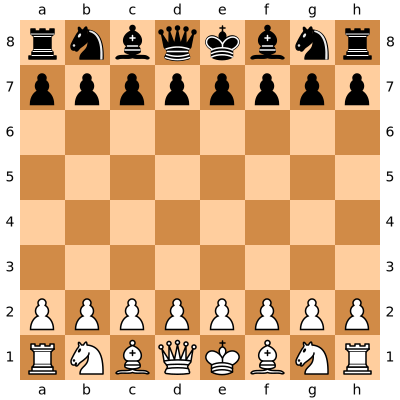

In [63]:
if mode == MODE_CHESS:
    start_board = chess.Board()
elif mode == MODE_CRAZYHOUSE:
    start_board = chess.variant.CrazyhouseBoard()
else:
    start_board = planes_to_board(x_val[idx], normalized_input=tc.normalize, mode=mode)
board = start_board
print(chess.COLOR_NAMES[board.turn])
if board.uci_variant == "crazyhouse":
    print(board.pockets)
board

In [64]:
def predict_single(net, x, select_policy_from_plane=False):
    
    out = [None, None]
    if tc.framework == 'mxnet' or tc.framework == 'gluon':
        pred = net(mx.nd.array(np.expand_dims(x, axis=0), ctx=ctx))
        out[0] = pred[0].asnumpy()
        out[1] = pred[1].softmax().asnumpy()
    elif tc.framework == 'pytorch':
        with torch.no_grad():
            pred = net(torch.Tensor(np.expand_dims(x, axis=0)).to(ctx))
            out[0] = pred[0].to(torch.device("cpu")).numpy()
            out[1] = pred[1].to(torch.device("cpu")).softmax(dim=1).numpy()
    if select_policy_from_plane:
        out[1] = out[1][:, FLAT_PLANE_IDX]
    
    return out

In [65]:
if tc.framework == 'pytorch':
    net = model
    net.eval()

In [66]:
x_start_pos = board_to_planes(board, normalize=tc.normalize, mode=mode)
pred = predict_single(net, x_start_pos, tc.select_policy_from_plane)
pred

[array([[0.09575456]], dtype=float32),
 array([[2.4178237e-07, 4.4941314e-07, 3.3471585e-07, ..., 2.3605472e-07,
         1.5421448e-07, 2.5773116e-07]], dtype=float32)]

In [67]:
policy_to_best_move(board, yp_val[idx])

(Move.from_uci('e2e4'), 1.0)

In [68]:
opts = 5
selected_moves, probs = policy_to_moves(board, pred[1][0])
selected_moves[:opts]

[Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('g1f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('g2g3')]

[Text(0, 4, 'e2e4'),
 Text(0, 3, 'd2d4'),
 Text(0, 2, 'g1f3'),
 Text(0, 1, 'e2e3'),
 Text(0, 0, 'g2g3')]

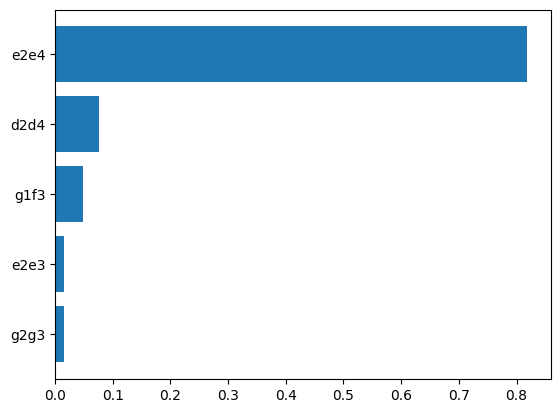

In [69]:
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves[:opts])

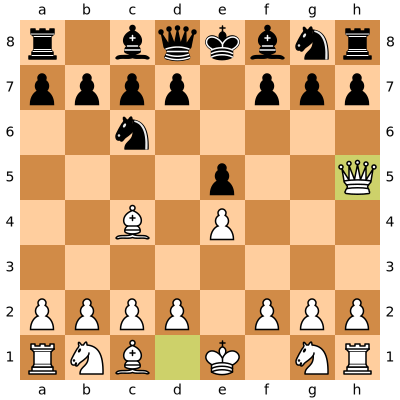

In [70]:
board = start_board
board.push_uci('e2e4')
board.push_uci('e7e5')
board.push_uci('f1c4')
board.push_uci('b8c6')
board.push_uci('d1h5')
x_scholar_atck = board_to_planes(board, normalize=tc.normalize, mode=mode)
board

[Text(0, 4, 'g7g6'),
 Text(0, 3, 'g8f6'),
 Text(0, 2, 'f8e7'),
 Text(0, 1, 'f8c5'),
 Text(0, 0, 'd8e7')]

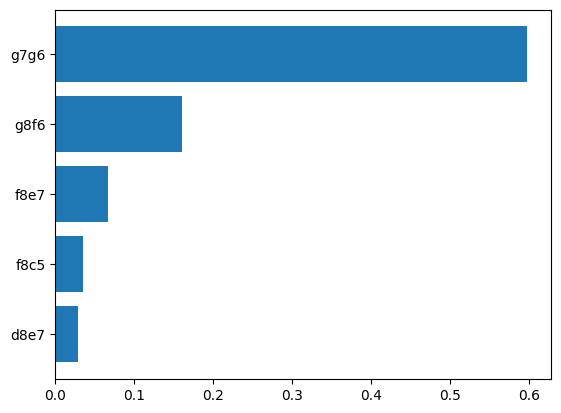

In [71]:
pred = predict_single(net, x_scholar_atck, tc.select_policy_from_plane)

selected_moves, probs = policy_to_moves(board, pred[1][0])
plt.barh(range(opts)[::-1], probs[:opts])
ax = plt.gca()
ax.set_yticks(range(opts)[::-1])
ax.set_yticklabels(selected_moves[:opts])

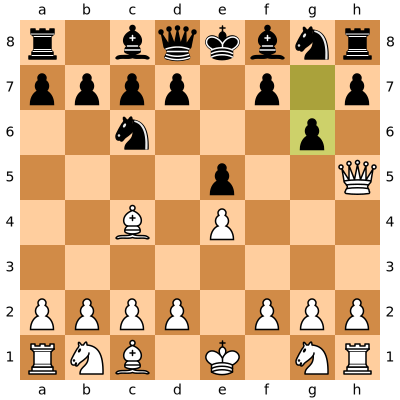

In [72]:
board.push(selected_moves[0])
board

### Performance on test dataset


In [73]:
s_idcs_test, x_test, yv_test, yp_test, yplys_test, pgn_datasets_test = load_pgn_dataset(dataset_type='test', part_id=0,
                                                                               verbose=True, normalize=True)
test_data = get_data_loader(x_test, yv_test, yp_test, yplys_test, tc, shuffle=False)

2023-10-23 03:40:03 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/test\2021-01-12-14-14-42\lichess_db_crazyhouse_rated_2018-08_0.zip ...
2023-10-23 03:40:03 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/test\2021-01-12-14-14-42\lichess_db_crazyhouse_rated_2018-08_0.zip ...
2023-10-23 03:40:03 root[7116] DEBUG 
2023-10-23 03:40:03 root[7116] DEBUG 
2023-10-23 03:40:03 root[7116] INFO STATISTICS:
2023-10-23 03:40:03 root[7116] INFO STATISTICS:
black_wins [443]
draws [5]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [552]
2023-10-23 03:40:03 root[7116] INFO PARAMETERS:
2023-10-23 03:40:03 root[7116] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-08.pgn']
termination_conditions [b'Normal']


In [74]:
if tc.framework == 'mxnet':
    metrics = metrics_gluon

evaluate_metrics(to.metrics, test_data, net, nb_batches=None, sparse_policy_label=tc.sparse_policy_label, ctx=ctx,
                 apply_select_policy_from_plane=tc.select_policy_from_plane, use_wdl=tc.use_wdl,
                 use_plys_to_end=tc.use_plys_to_end)

{'loss': tensor(1.6812, device='cuda:0'),
 'value_loss': tensor(0.8269, device='cuda:0'),
 'policy_loss': tensor(1.6898, device='cuda:0'),
 'value_acc_sign': tensor(0.6580, device='cuda:0'),
 'policy_acc': 0.49636576372145796,
 'wdl_loss': tensor(0.6279, device='cuda:0'),
 'wdl_acc': 0.6544639058289604,
 'plys_to_end_loss': tensor(0.0283, device='cuda:0')}

### Show result on mate-in-one problems

In [75]:
s_idcs_mate, x_mate, yv_mate, yp_mate, yplys_mate, pgn_dataset_mate = load_pgn_dataset(dataset_type='mate_in_one', part_id=0,
                                                                              verbose=True, normalize=tc.normalize)
yplys_mate = np.ones(len(yv_mate))
mate_data = get_data_loader(x_mate, yv_mate, yp_mate, yplys_mate, tc, shuffle=False)

2023-10-23 03:40:21 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/mate_in_one\2021-01-12-14-14-59\lichess_db_crazyhouse_rated_2018-04_0.zip ...
2023-10-23 03:40:21 root[7116] DEBUG loading: D:/Masterarbeit/datasets/datasets/24k_dataset/default/planes/mate_in_one\2021-01-12-14-14-59\lichess_db_crazyhouse_rated_2018-04_0.zip ...
2023-10-23 03:40:21 root[7116] DEBUG 
2023-10-23 03:40:21 root[7116] DEBUG 
2023-10-23 03:40:21 root[7116] INFO STATISTICS:
2023-10-23 03:40:21 root[7116] INFO STATISTICS:
black_wins [430]
draws [0]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [570]
2023-10-23 03:40:21 root[7116] INFO PARAMETERS:
2023-10-23 03:40:21 root[7116] INFO PARAMETERS:
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'lichess_db_crazyhouse_rated_2018-04.pgn']
termination_conditions [b'Normal']


### Mate In One Performance

In [76]:
evaluate_metrics(to.metrics, mate_data, net, nb_batches=None, sparse_policy_label=tc.sparse_policy_label, ctx=ctx,
                 apply_select_policy_from_plane=tc.select_policy_from_plane, use_wdl=tc.use_wdl,
                 use_plys_to_end=tc.use_plys_to_end)

{'loss': tensor(1.5049, device='cuda:0'),
 'value_loss': tensor(0.2641, device='cuda:0'),
 'policy_loss': tensor(1.5174, device='cuda:0'),
 'value_acc_sign': tensor(0.9200, device='cuda:0'),
 'policy_acc': 0.521,
 'wdl_loss': tensor(0.2396, device='cuda:0'),
 'wdl_acc': 0.92,
 'plys_to_end_loss': tensor(0.0288, device='cuda:0')}

### Show some example mate problems

In [77]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Evaluate Performance

In [78]:
def eval_pos(net, x_mate, yp_mate, verbose=False, select_policy_from_plane=False):
    
    board = planes_to_board(x_mate, normalized_input=tc.normalize, mode=mode)
    if verbose is True:
        print("{0}'s turn".format(chess.COLOR_NAMES[board.turn]))
        if board.uci_variant == "crazyhouse":
            print("black/white {0}".format(board.pockets))
    pred = predict_single(net, x_mate, select_policy_from_plane=select_policy_from_plane)
    
    true_move = policy_to_move(yp_mate, mirror_policy=board.turn==chess.BLACK)
    
    opts = 5
    pred_moves, probs = policy_to_moves(board, pred[1][0])
    pred_moves = pred_moves[:opts]
    
    legal_move_cnt = board.legal_moves.count()
    mate_move_cnt = str(board.legal_moves).count('#')
    
    is_mate_5_top = False
    
    for pred_move in pred_moves:
        board_5_top = deepcopy(board)
        board_5_top.push(pred_move)
        if board_5_top.is_checkmate() is True:
            is_mate_5_top = True
            break
    
    board.push(pred_moves[0])
    
    is_checkmate = False
    if board.is_checkmate() is True:
        is_checkmate = True
        
    filtered_pred = sorted(pred[1][0], reverse=True)
    
    if verbose is True:
        plt.barh(range(opts)[::-1], filtered_pred[:opts])
        ax = plt.gca()
        ax.set_yticks(range(opts)[::-1])
        ax.set_yticklabels(pred_moves)
        plt.title('True Move:' + str(true_move) +
                 '\nEval:' + str(pred[0][0]))
        plt.show()
    
    return pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt

In [79]:
nb_pos = len(x_mate)
mates_found = []
mates_5_top_found = []
legal_mv_cnts = []
mate_mv_cnts = []

for i in range(nb_pos):
    pred, pred_moves, true_move, board, is_mate, is_mate_5_top, legal_mv_cnt, mate_mv_cnt= eval_pos(net, x_mate[i], yp_mate[i], select_policy_from_plane=tc.select_policy_from_plane)
    mates_found.append(is_mate)
    legal_mv_cnts.append(legal_mv_cnt)
    mate_mv_cnts.append(mate_mv_cnt)
    mates_5_top_found.append(is_mate_5_top)

In [80]:
np.array(mate_mv_cnts).mean()

1.623

In [81]:
np.array(legal_mv_cnts).mean()

115.862

### Random Guessing Baseline

In [82]:
np.array(mate_mv_cnts).mean() / np.array(legal_mv_cnts).mean()

0.014008044052407175

### Prediciton Performance

In [83]:
print('mate_in_one_acc:', sum(mates_found) / nb_pos)

mate_in_one_acc: 0.645


In [84]:
sum(mates_5_top_found) / nb_pos

0.942

In [85]:
pgn_dataset_mate.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='metadata (1001, 18) |…

In [86]:
metadata = np.array(pgn_dataset_mate['metadata'])
metadata[0, :]
metadata[1, :]

array([b'Event', b'Site', b'Date', b'Round', b'White', b'Black',
       b'Result', b'BlackElo', b'BlackRatingDiff', b'BlackTitle',
       b'Termination', b'TimeControl', b'UTCDate', b'UTCTime', b'Variant',
       b'WhiteElo', b'WhiteRatingDiff', b''], dtype='|S128')

array([b'Rated Crazyhouse tournament https://lichess.org/tournament/EkplkgHV',
       b'https://lichess.org/6XtZaN95', b'2018.03.31', b'-', b'mrsjadk26',
       b'beatles_21', b'1-0', b'2101', b'-11', b'FM', b'Normal', b'180+0',
       b'2018.03.31', b'22:00:44', b'Crazyhouse', b'2158', b'+11', b''],
      dtype='|S128')

In [87]:
site_mate = metadata[1:, 1]

In [88]:
def clean_string(np_string):
    string = str(site_mate[i]).replace("b'", "")
    string = string.replace("'", "")
    string = string.replace('"', '')
    
    return string

In [89]:
import chess.svg
from IPython.display import SVG, HTML

## Show the result of the first 17 examples

https://lichess.org/6XtZaN95
white's turn
black/white [CrazyhousePocket('qbnp'), CrazyhousePocket('rn')]
2023-10-23 03:40:44 matplotlib.font_manager[7116] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-10-23 03:40:44 matplotlib.font_manager[7116] DEBUG findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2023-10-23 03:40:44 matplotlib.font_manager[7116] DEBUG findfont: score(FontEntry(fname='c:\\ProgramData\\anaconda3\\envs\\py38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-10-23 03:40:44 matplotlib.font_manager[7116] DEBUG findfont: score(FontEntry(fname='c:\\ProgramData\\anaconda3\\envs\\py38\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', wei

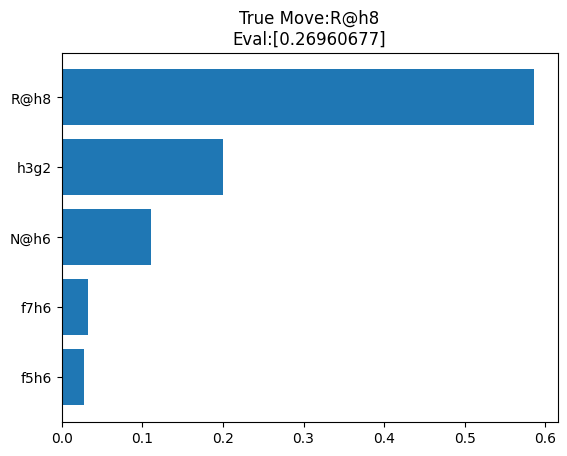

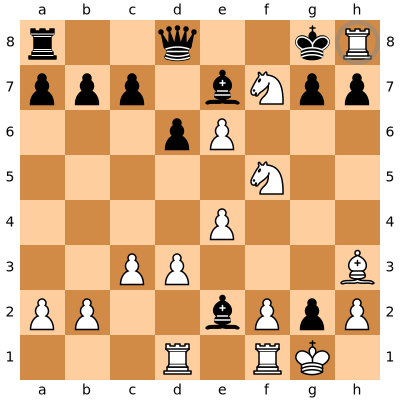

https://lichess.org/aGh9J93k
white's turn
black/white [CrazyhousePocket('qbp'), CrazyhousePocket('rbbbnnn')]


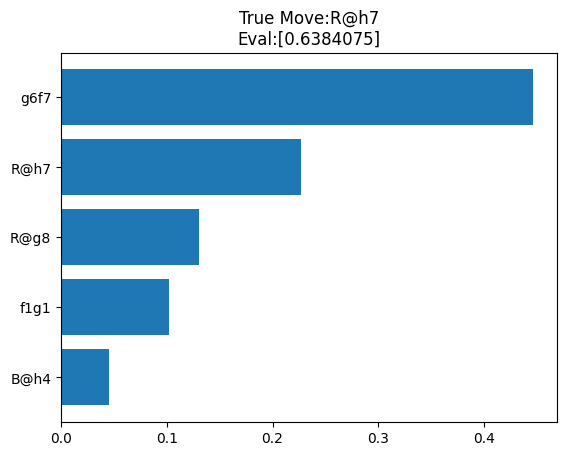

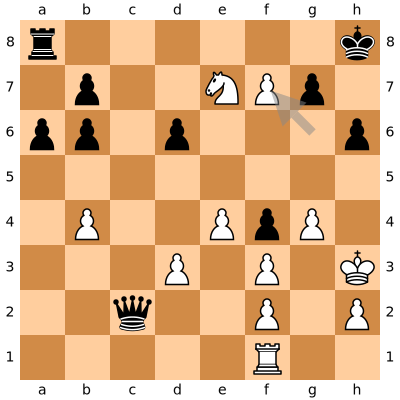

https://lichess.org/N65IVIw4
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnnpppp')]


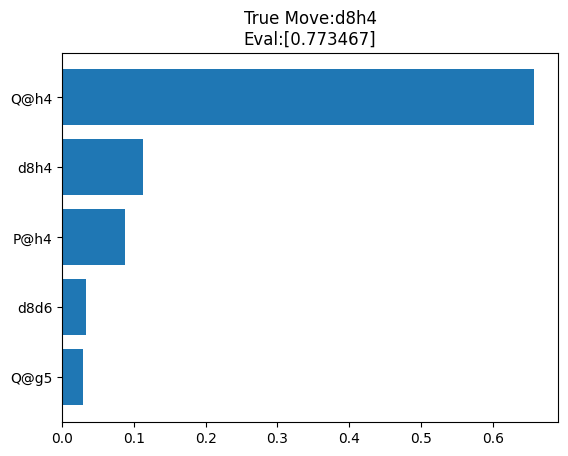

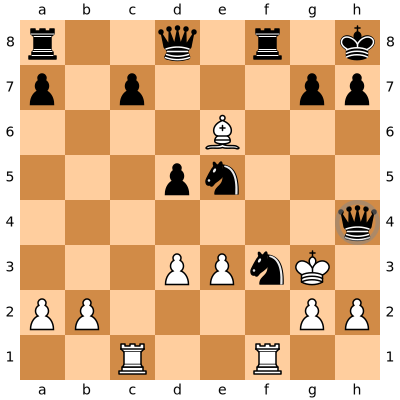

https://lichess.org/zr1Y3Yk0
black's turn
black/white [CrazyhousePocket('npp'), CrazyhousePocket('rbbnnp')]


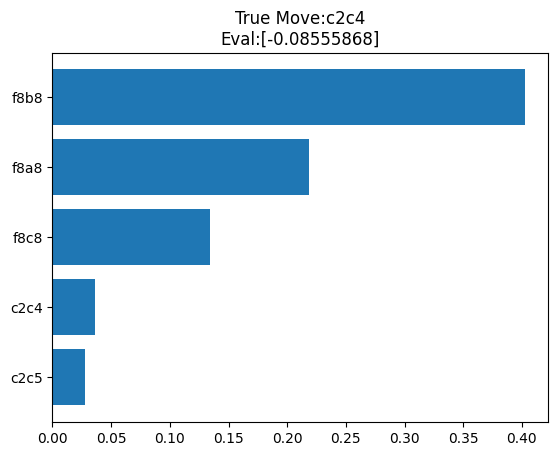

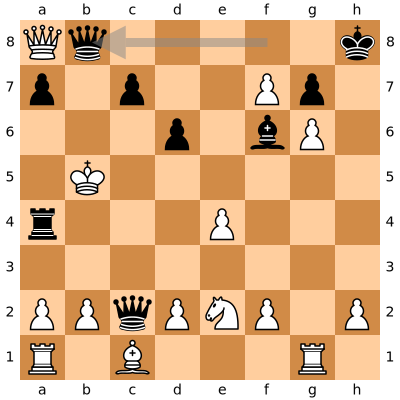

https://lichess.org/BcOhX1Tf
black's turn
black/white [CrazyhousePocket('pp'), CrazyhousePocket('qrrbbbnnpp')]


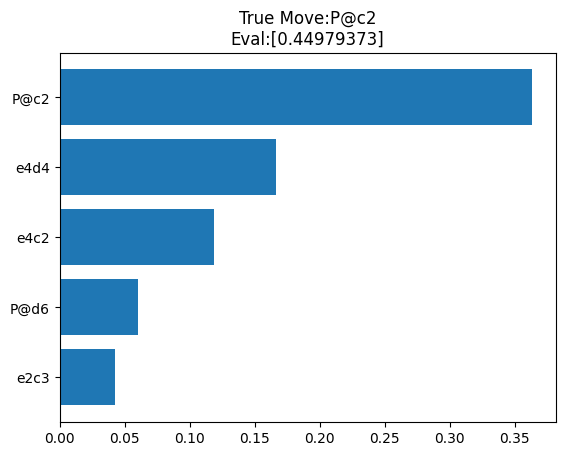

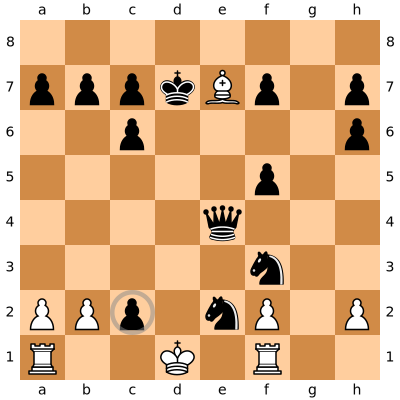

https://lichess.org/NgHPT61x
white's turn
black/white [CrazyhousePocket('qrnppp'), CrazyhousePocket('bnp')]


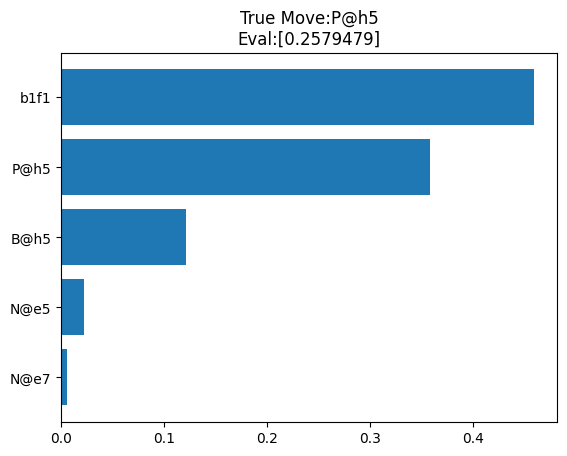

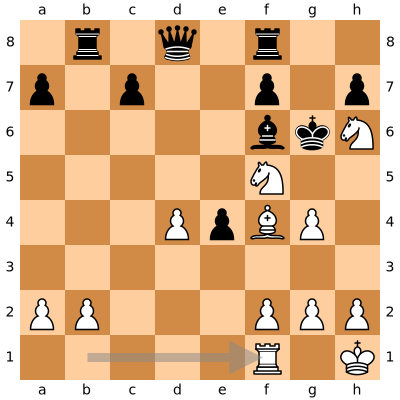

https://lichess.org/JaZSHQvm
black's turn
black/white [CrazyhousePocket('n'), CrazyhousePocket('pppp')]


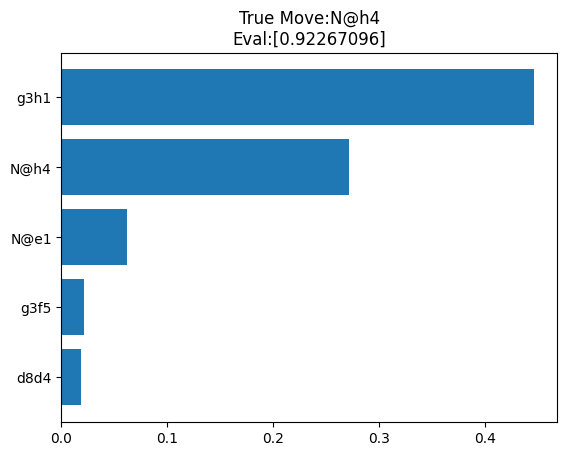

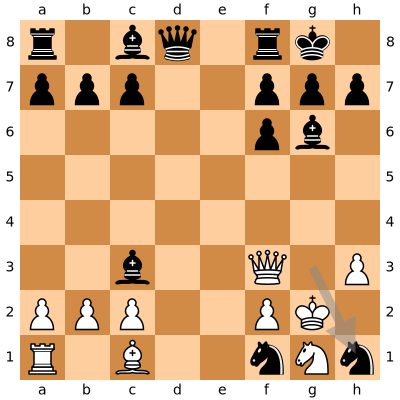

https://lichess.org/aEkH467l
white's turn
black/white [CrazyhousePocket('bpppp'), CrazyhousePocket('r')]


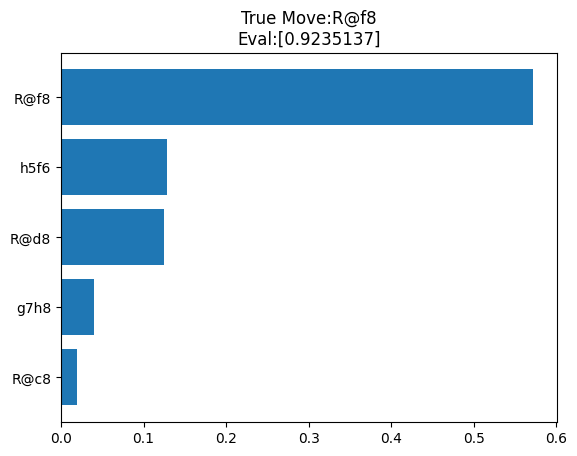

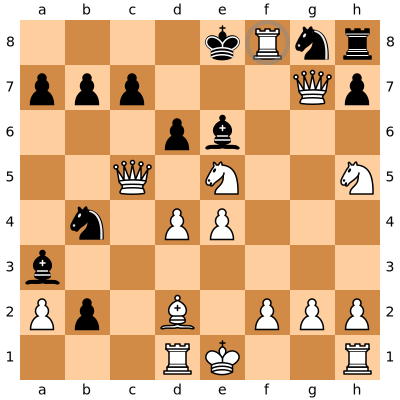

https://lichess.org/AXHqFp0W
white's turn
black/white [CrazyhousePocket('bbbp'), CrazyhousePocket('npp')]


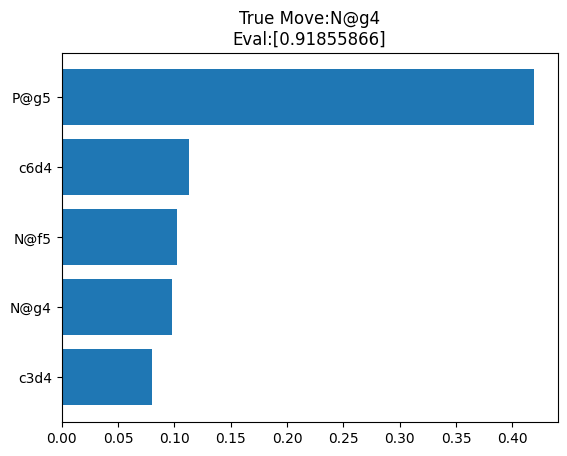

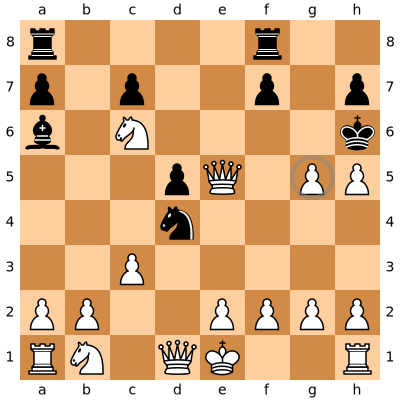

https://lichess.org/koKV9oe5
black's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('nppp')]


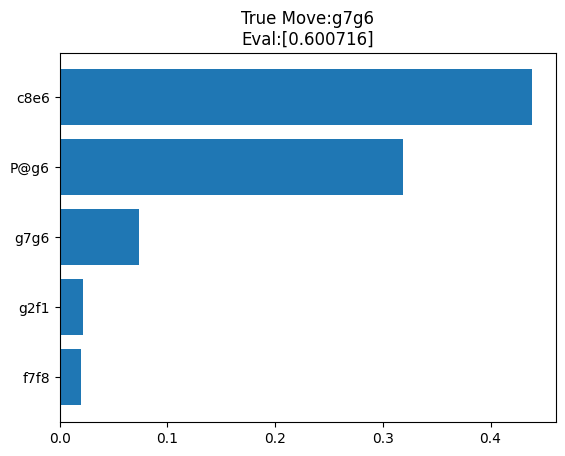

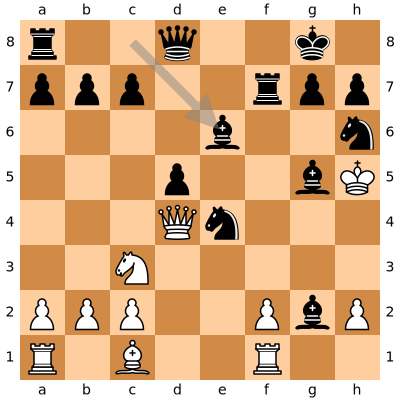

https://lichess.org/l30GAIip
black's turn
black/white [CrazyhousePocket('rbbnpp'), CrazyhousePocket('rp')]


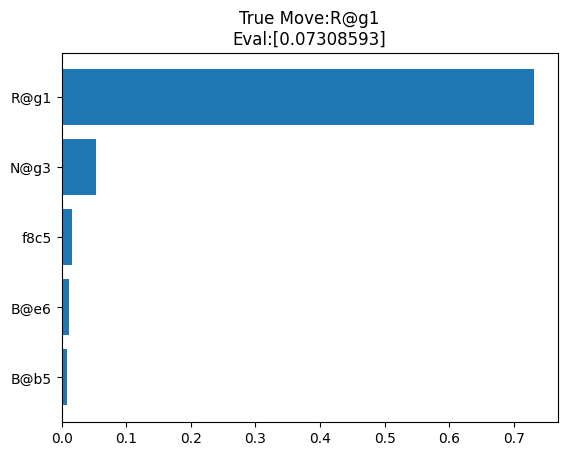

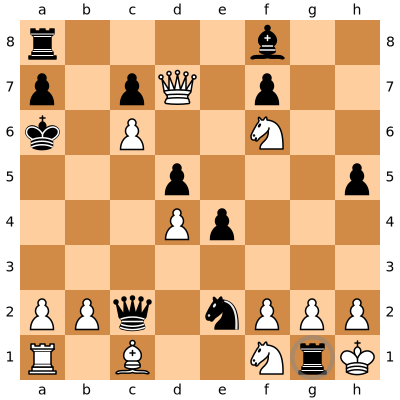

https://lichess.org/qSMyFbYs
white's turn
black/white [CrazyhousePocket('qnn'), CrazyhousePocket('bb')]


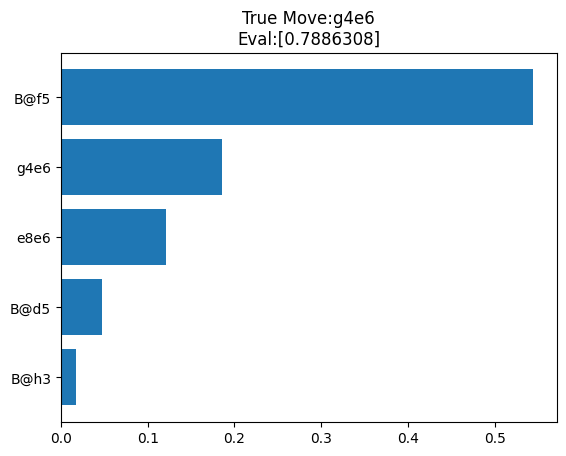

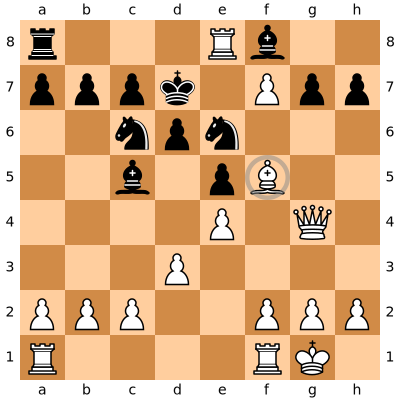

https://lichess.org/CUT8OfGV
white's turn
black/white [CrazyhousePocket('qrbb'), CrazyhousePocket('rnnnpp')]


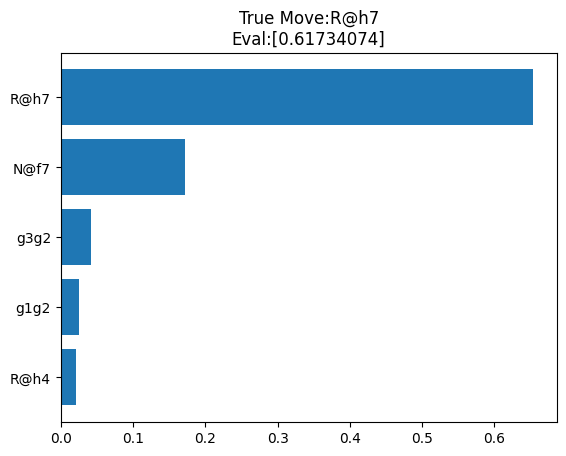

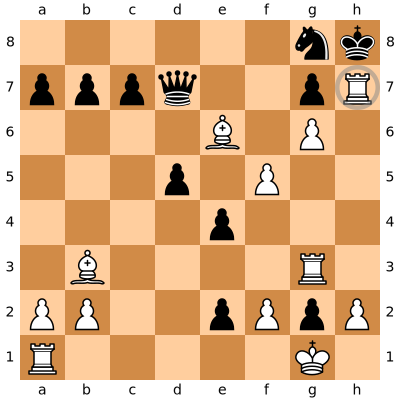

https://lichess.org/N9R4ohE6
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bbbnn')]


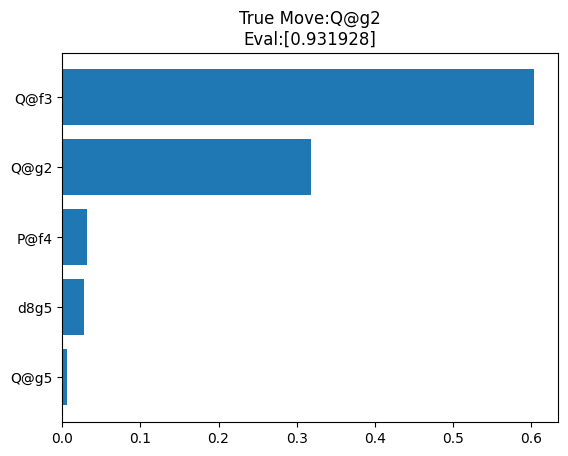

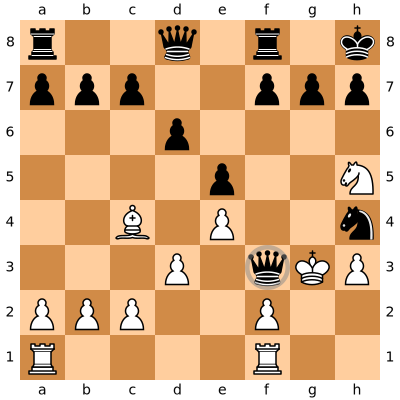

https://lichess.org/uN2inbhr
black's turn
black/white [CrazyhousePocket('q'), CrazyhousePocket('rrppppp')]


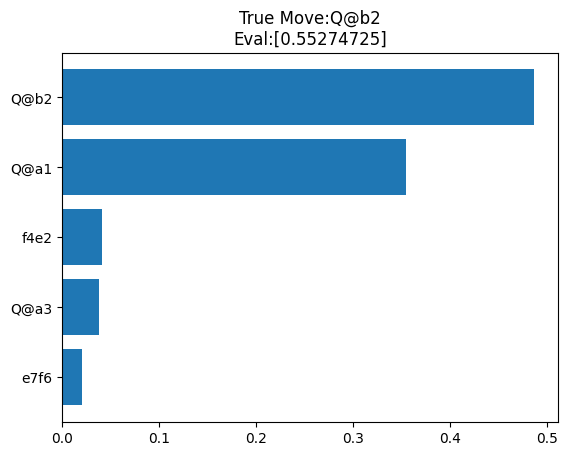

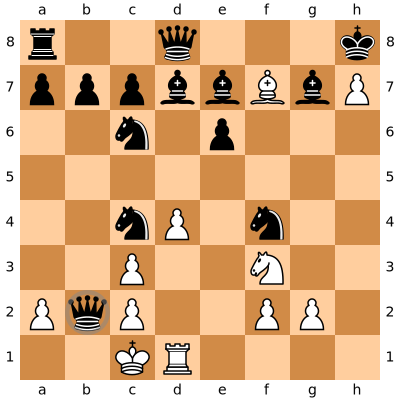

https://lichess.org/N4IMyBUG
black's turn
black/white [CrazyhousePocket('rnppp'), CrazyhousePocket('')]


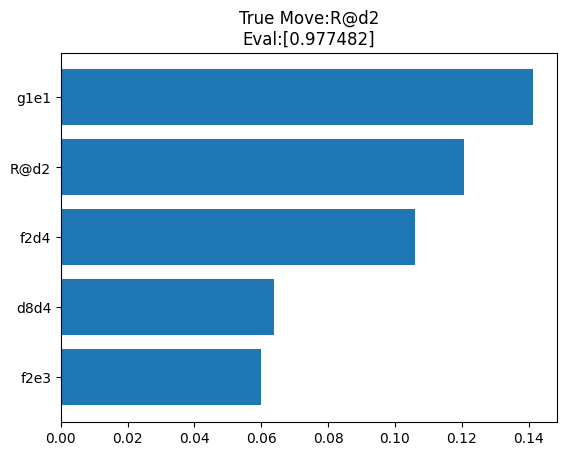

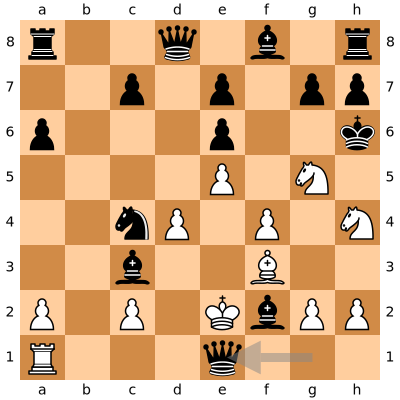

https://lichess.org/wkHxsIKQ
white's turn
black/white [CrazyhousePocket('qbbbnnp'), CrazyhousePocket('rbpp')]


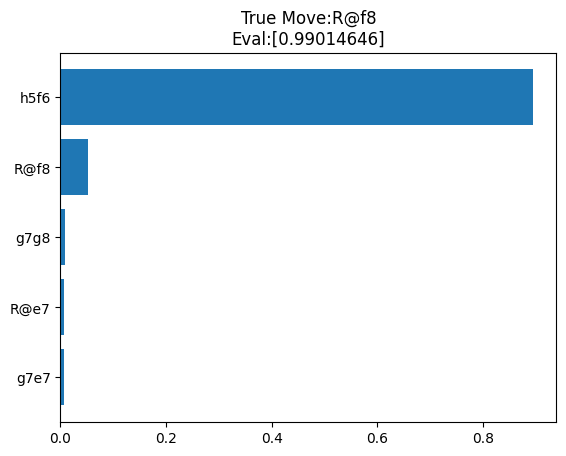

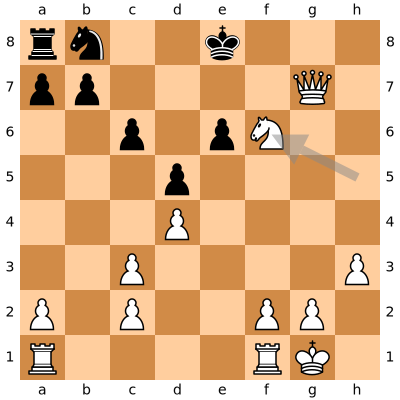

In [90]:
for i in range(17):
    print(clean_string(site_mate[i]))
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True, select_policy_from_plane=tc.select_policy_from_plane)
    pred_move = pred_moves[0]
    pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
    SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))

## Show examples where it failed

https://lichess.org/LsrFs69R
black's turn
black/white [CrazyhousePocket('pp'), CrazyhousePocket('qrrbnnpppp')]


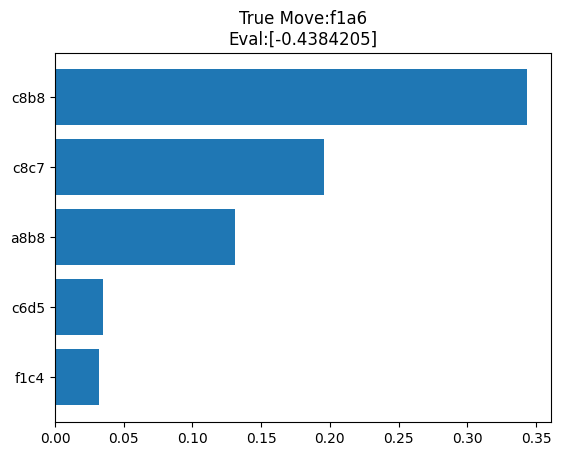

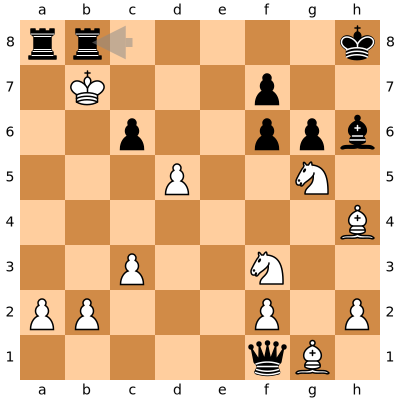

https://lichess.org/Agj9GlEo
white's turn
black/white [CrazyhousePocket('nnpppp'), CrazyhousePocket('p')]


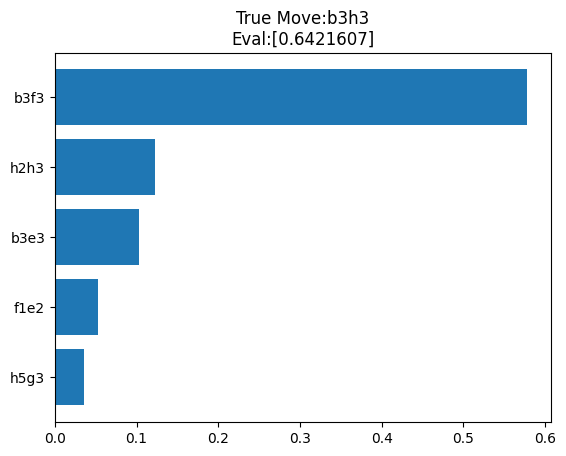

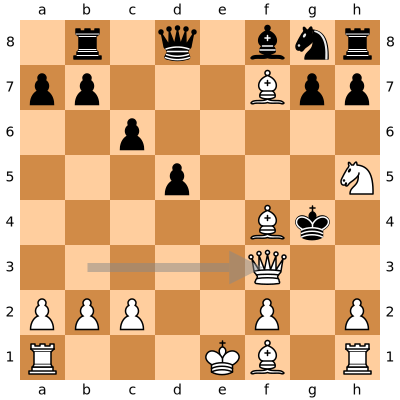

https://lichess.org/fZhepcrV
black's turn
black/white [CrazyhousePocket(''), CrazyhousePocket('nnppp')]


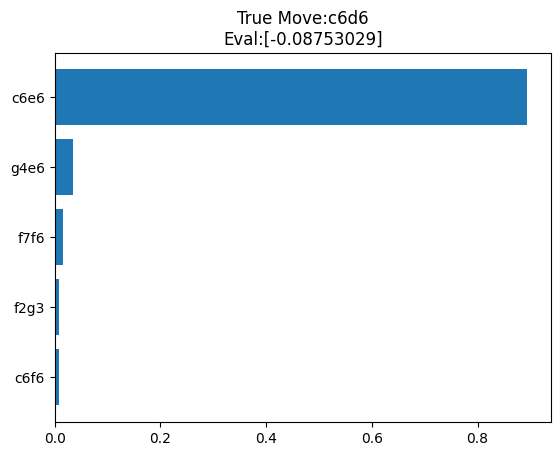

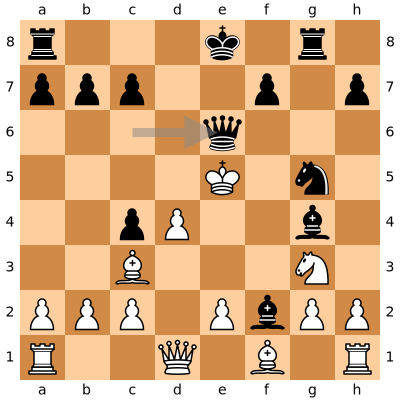

https://lichess.org/k1k0wX9
black's turn
black/white [CrazyhousePocket('qrbnnpp'), CrazyhousePocket('n')]


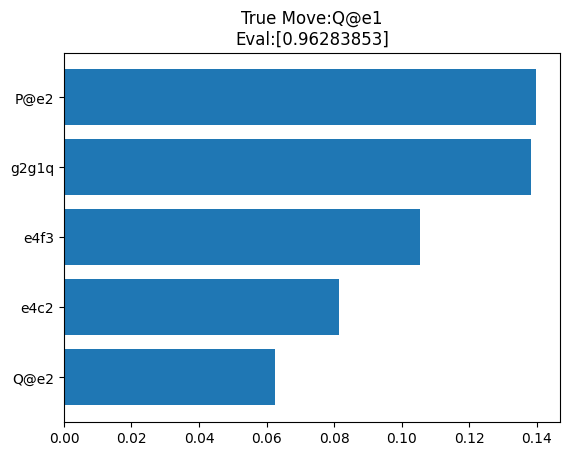

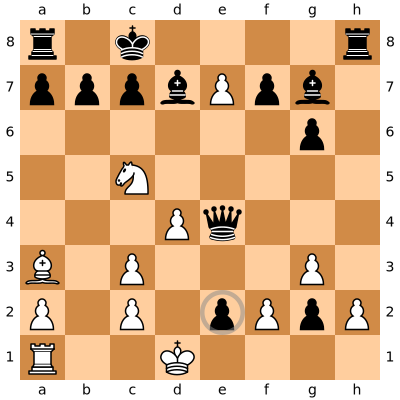

https://lichess.org/kNka9sCA
white's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('rn')]


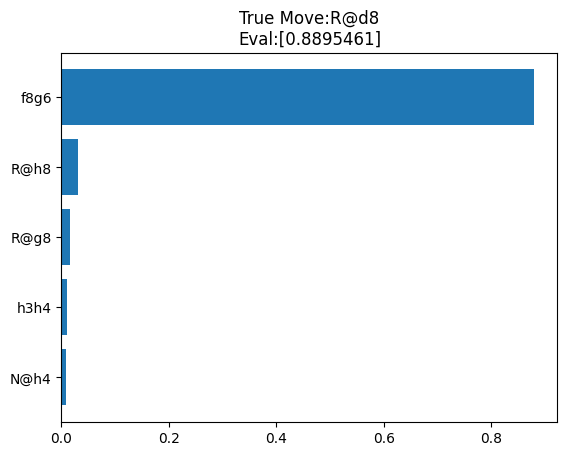

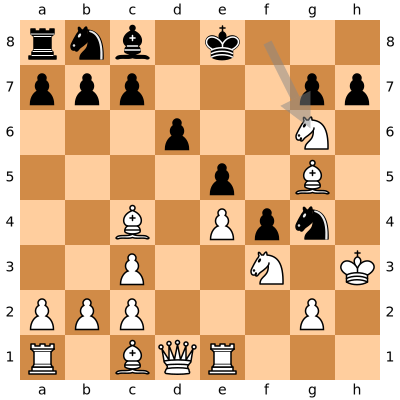

https://lichess.org/DOgF5Y2H
black's turn
black/white [CrazyhousePocket('qbnnnp'), CrazyhousePocket('bp')]


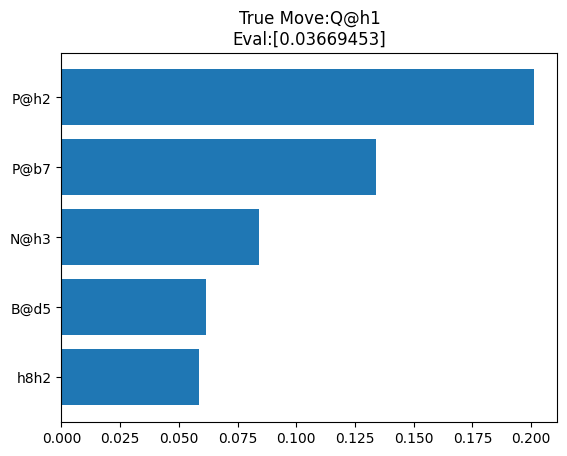

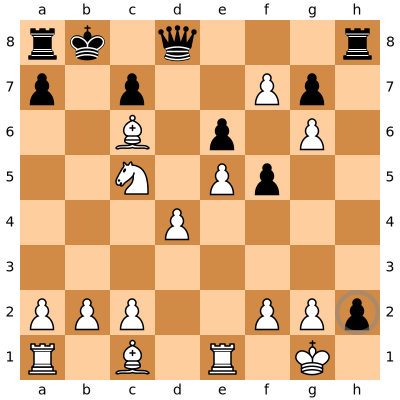

https://lichess.org/mZcJJn3R
white's turn
black/white [CrazyhousePocket('nnn'), CrazyhousePocket('qbppp')]


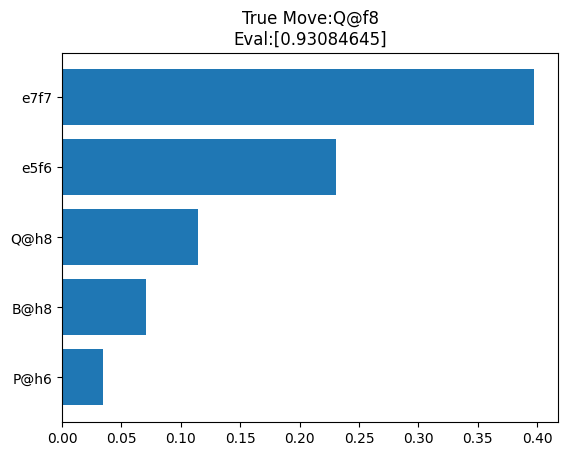

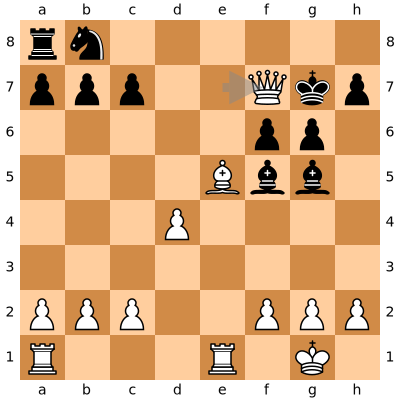

https://lichess.org/TZtkWbjF
black's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('npp')]


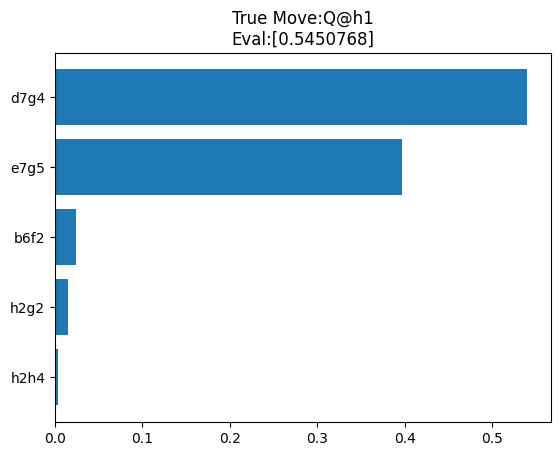

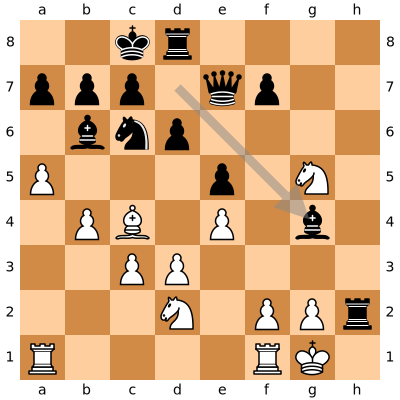

https://lichess.org/J8osqaiJ
white's turn
black/white [CrazyhousePocket('qp'), CrazyhousePocket('bp')]


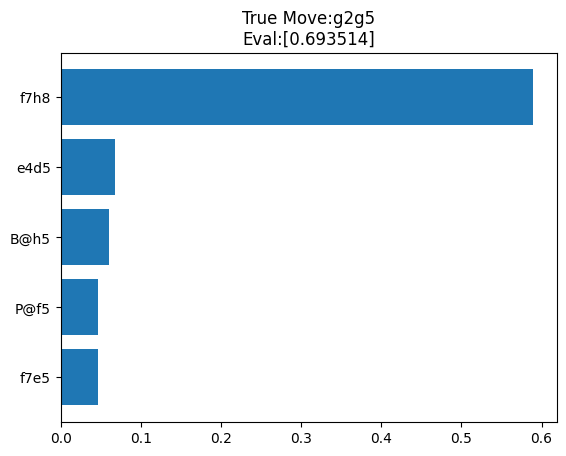

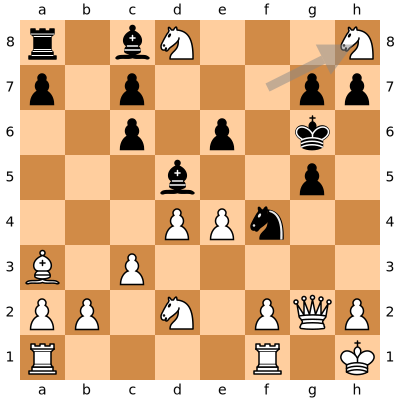

https://lichess.org/8as2s9YA
black's turn
black/white [CrazyhousePocket('rbnpppp'), CrazyhousePocket('q')]


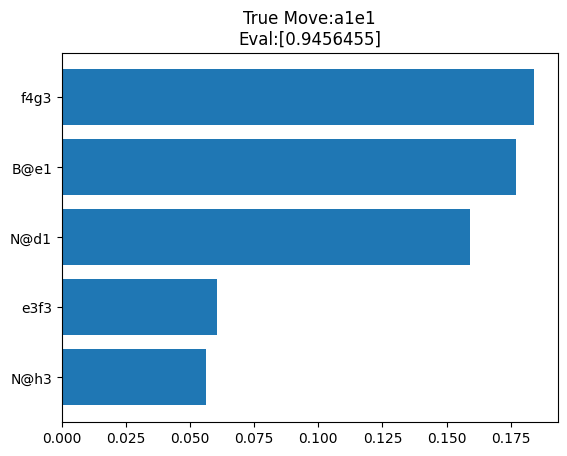

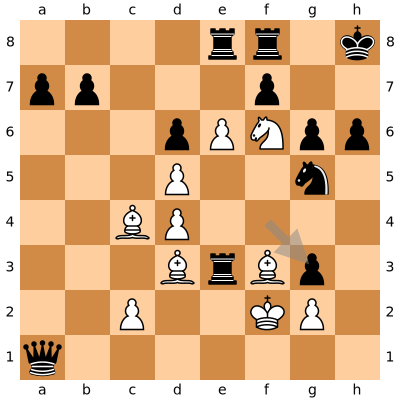

https://lichess.org/jaUpY5ZB
black's turn
black/white [CrazyhousePocket('np'), CrazyhousePocket('qqrnnnp')]


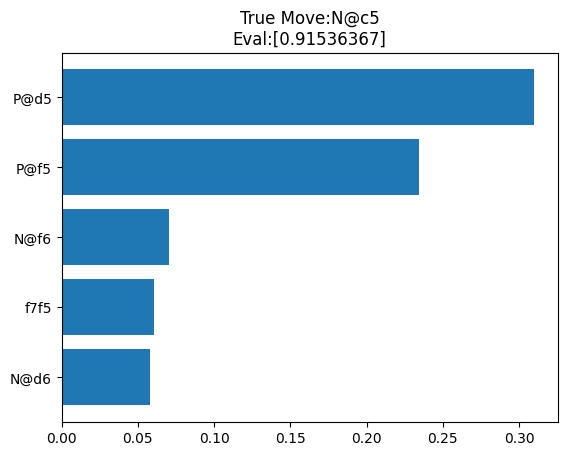

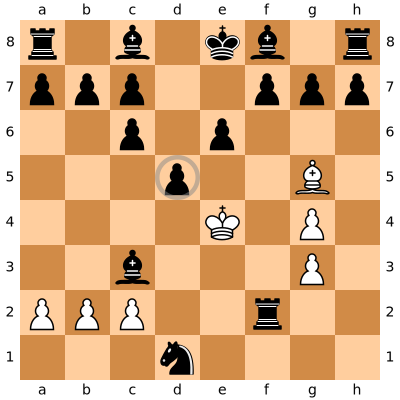

https://lichess.org/8zdc9Pp4
black's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('nnp')]


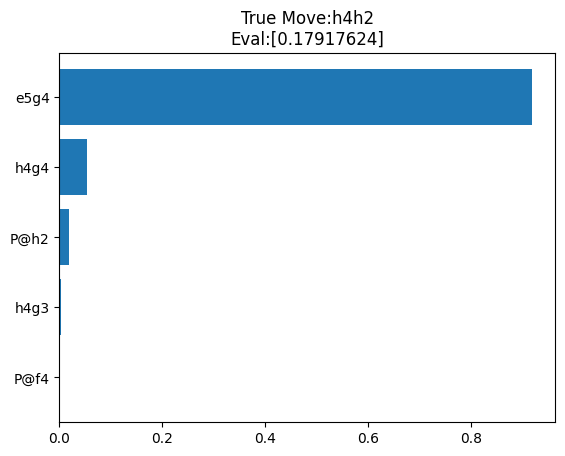

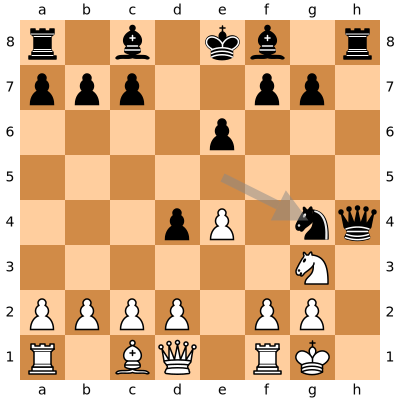

https://lichess.org/XH0LYkRO
white's turn
black/white [CrazyhousePocket('p'), CrazyhousePocket('q')]


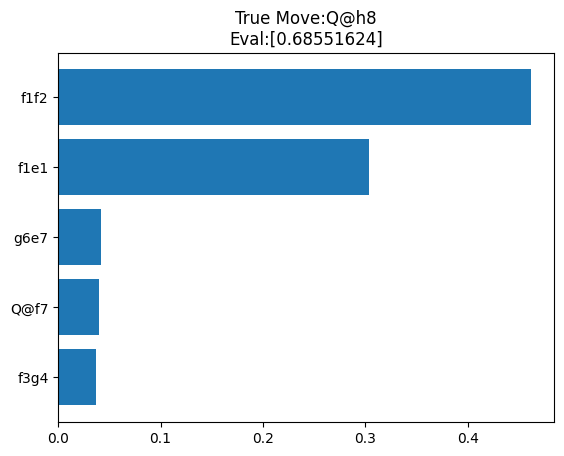

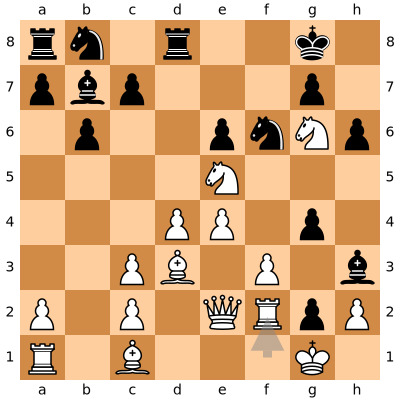

https://lichess.org/3s6SaZ1r
black's turn
black/white [CrazyhousePocket('qrp'), CrazyhousePocket('p')]


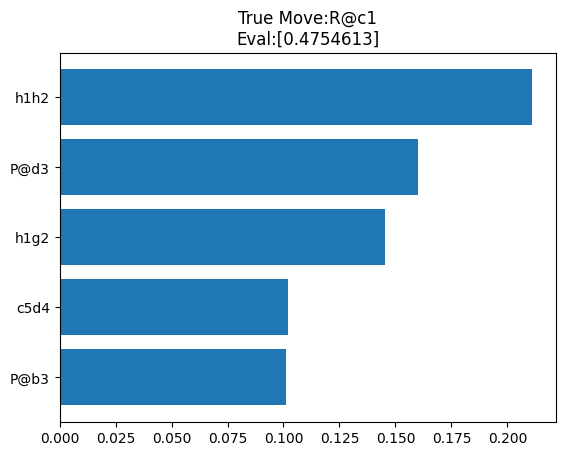

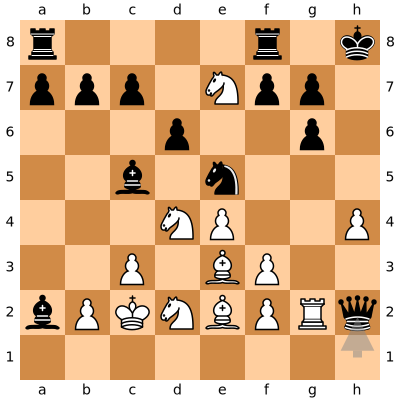

https://lichess.org/FayZL9RO
white's turn
black/white [CrazyhousePocket('rp'), CrazyhousePocket('qbp')]


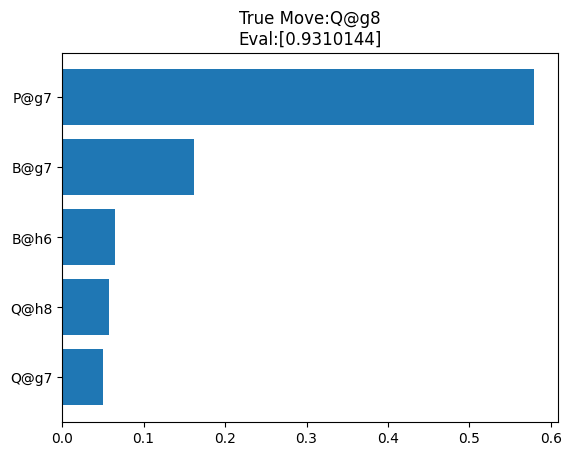

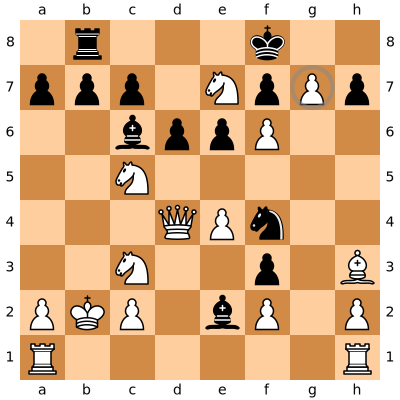

In [91]:
mate_missed = 0
for i in range(1000):
    pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=False, select_policy_from_plane=tc.select_policy_from_plane)
    if is_mate_5_top is False:
        mate_missed += 1
        print(clean_string(site_mate[i]))
        pred, pred_moves, true_move, board, is_checkmate, is_mate_5_top, legal_move_cnt, mate_move_cnt = eval_pos(net, x_mate[i], yp_mate[i], verbose=True, select_policy_from_plane=tc.select_policy_from_plane)
        pred_move = pred_moves[0]
        pred_arrow = chess.svg.Arrow(pred_move.from_square, pred_move.to_square)
        SVG(data=chess.svg.board(board=board, arrows=[pred_arrow], size=400))
    if mate_missed == 15:
        break